# Segment Shuffle Augmentation Analysis

Run cells 1-12 in order. Each cell is labeled with what it does.

In [1]:
# [1] IMPORTS
import sys; sys.path.append('../src')
import numpy as np, pandas as pd, polars as pl, matplotlib.pyplot as plt, os, warnings, scipy.optimize
from matplotlib.patches import Rectangle, Polygon, Circle
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from tqdm.notebook import tqdm
import SPTnano as spt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
print('Imports done')

Config module loaded. Master directory is: D:/TRANSFORMER_DEVELOPMENT/
Imports done


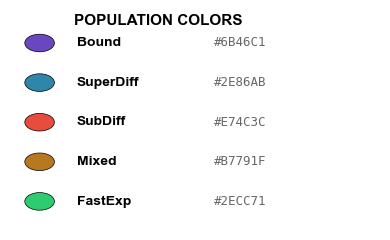

In [2]:
# [2] POPULATION COLORS KEY
POP_COLORS = {
    'bound_stationary': '#6B46C1',
    'superdiffusive_transport': '#2E86AB',
    'subdiffusive_motion': '#E74C3C',
    'mixed_exploratory_bound': '#B7791F',
    'fast_exploratory': '#2ECC71',
    'ungatedgate1': '#AAAAAA',
    'ungatedgate2': '#AAAAAA',
    'unknown': '#888888',
}
POP_ABBREV = {
    'bound_stationary': 'Bound',
    'superdiffusive_transport': 'SuperDiff',
    'subdiffusive_motion': 'SubDiff',
    'mixed_exploratory_bound': 'Mixed',
    'fast_exploratory': 'FastExp',
}
POP_ORDER = ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory']

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.axis('off')
for i, pop in enumerate(POP_ORDER):
    y = 0.85 - i*0.18
    ax.add_patch(Circle((0.08, y), 0.04, fc=POP_COLORS[pop], ec='black', lw=0.5))
    ax.text(0.18, y, POP_ABBREV[pop], fontsize=10, fontweight='bold', va='center')
    ax.text(0.55, y, POP_COLORS[pop], fontsize=9, va='center', family='monospace', color='#666')
ax.text(0.4, 0.98, 'POPULATION COLORS', fontsize=11, fontweight='bold', va='top', ha='center')
plt.tight_layout()
plt.show()

In [3]:
# DIAG-2: Check colors defined
print("DIAG-2: Population colors check")
print(f"  POP_COLORS keys: {list(POP_COLORS.keys())}")
print(f"  POP_ORDER: {POP_ORDER}")
print(f"  All 5 pops in POP_COLORS? {all(p in POP_COLORS for p in POP_ORDER)}")

DIAG-2: Population colors check
  POP_COLORS keys: ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory', 'ungatedgate1', 'ungatedgate2', 'unknown']
  POP_ORDER: ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory']
  All 5 pops in POP_COLORS? True


In [4]:
# [3] CONFIGURATION
DATA_DRIVE = 'F:'
DATA_DIR = f'{DATA_DRIVE}/Analyzed/HIERARCHICAL_GATES_20260119_102840'
INSTANT_DF_PATH = os.path.join(DATA_DIR, 'instant_df_hierarchical_gates.parquet')
WINDOWED_DF_PATH = os.path.join(DATA_DIR, 'windowed_df_hierarchical_gates.parquet')
OUTPUT_FOLDER = Path('D:/TRANSFORMER_DEVELOPMENT/plots/segment_shuffle_analysis')
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
N_TRACKS_PER_POP, N_TRACKS_VIZ, SEED = 60, 1, 42
np.random.seed(SEED)
GATE1_RECTS = {
    'low_speed_low_intersections': {'x': (0.0, 0.2), 'y': (0.0, 0.14), 'color': '#6B46C1'},
    'high_speed_low_intersections': {'x': (0.2, 1.0), 'y': (0.0, 0.14), 'color': '#2E86AB'},
    'low_speed_high_intersections': {'x': (0.0, 0.3), 'y': (0.14, 1.0), 'color': '#B7791F'},
    'high_speed_high_intersections': {'x': (0.3, 1.0), 'y': (0.14, 1.0), 'color': '#2ECC71'},
}
# NOTE: cum_disp goes up to ~28, so set upper y-bound to 30!
# Diagonal boundary from (1.1, 0) to (2.825, 30), extended to y=30
GATE2_BOUNDS = {
    'superdiffusive': [(1.1, 0.0), (2.825, 30.0), (3.0, 30.0), (3.0, 0.0)],
    'subdiffusive': [(-0.5, 0.0), (-0.5, 30.0), (2.825, 30.0), (1.1, 0.0)],
}
print(f'Data: {DATA_DIR}')

Data: F:/Analyzed/HIERARCHICAL_GATES_20260119_102840


In [5]:
# [4] LOAD DATA
instant_df = pl.read_parquet(INSTANT_DF_PATH)
windowed_df = pl.read_parquet(WINDOWED_DF_PATH)
instant_df = instant_df.with_columns(pl.col('foldername').str.replace('Z:', DATA_DRIVE))
windowed_df = windowed_df.with_columns(pl.col('foldername').str.replace('Z:', DATA_DRIVE))
windowed_df = windowed_df.filter(pl.col('bad_fit_flag') == False)
windowed_df = windowed_df.filter(~pl.col('final_population').str.contains('ungated'))
valid_uids = windowed_df['window_uid'].unique().to_list()
instant_df = instant_df.filter(pl.col('window_uid').is_in(valid_uids))
print(f'Windowed: {windowed_df.shape}, Instant: {instant_df.shape}')
print(windowed_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True))

Windowed: (913237, 68), Instant: (34985130, 51)
shape: (5, 2)
┌──────────────────────────┬────────┐
│ final_population         ┆ n      │
│ ---                      ┆ ---    │
│ str                      ┆ u32    │
╞══════════════════════════╪════════╡
│ fast_exploratory         ┆ 557990 │
│ bound_stationary         ┆ 214035 │
│ subdiffusive_motion      ┆ 93908  │
│ mixed_exploratory_bound  ┆ 30863  │
│ superdiffusive_transport ┆ 16441  │
└──────────────────────────┴────────┘


In [6]:
# DIAG-4: Check data loaded correctly
print("DIAG-4: Data loading check")
print(f"  instant_df shape: {instant_df.shape}")
print(f"  windowed_df shape: {windowed_df.shape}")
print(f"  windowed_df populations:")
for p, n in windowed_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True).iter_rows():
    print(f"    {p}: {n:,}")
print(f"  All 5 target pops present? {all(p in windowed_df['final_population'].unique().to_list() for p in POP_ORDER)}")

DIAG-4: Data loading check
  instant_df shape: (34985130, 51)
  windowed_df shape: (913237, 68)
  windowed_df populations:
    fast_exploratory: 557,990
    bound_stationary: 214,035
    subdiffusive_motion: 93,908
    mixed_exploratory_bound: 30,863
    superdiffusive_transport: 16,441
  All 5 target pops present? True


In [7]:
# [5] HELPER FUNCTIONS
def parse_window_uid(wuid):
    parts = wuid.rsplit('_', 2)
    return '_'.join(parts[:-2]).rsplit('_', 1)[0], int(float(parts[-2])), int(float(parts[-1]))

def get_window_frames(df, wuid):
    uid, fs, fe = parse_window_uid(wuid)
    return df.filter((pl.col('unique_id') == uid) & (pl.col('frame') >= fs) & (pl.col('frame') <= fe)).sort('frame')

def calc_intersections(x, y):
    n = len(x)
    if n < 4: return 0
    pts = np.column_stack([x, y])
    ccw = lambda a,b,c: (c[1]-a[1])*(b[0]-a[0]) > (b[1]-a[1])*(c[0]-a[0])
    intersect = lambda a,b,c,d: ccw(a,c,d) != ccw(b,c,d) and ccw(a,b,c) != ccw(a,b,d)
    return sum(1 for i in range(n-1) for j in range(i+2, n-1) if intersect(pts[i], pts[i+1], pts[j], pts[j+1]))

def compute_features(x, y, dt_arr):
    dx, dy = np.diff(x), np.diff(y)
    steps = np.sqrt(dx**2 + dy**2)
    dta = np.asarray(dt_arr)[1:] if not np.isscalar(dt_arr) else dt_arr
    if not np.isscalar(dt_arr): dta = np.where((dta == 0) | np.isnan(dta), 1e-10, dta)
    speeds = steps / dta if np.isscalar(dta) else steps / dta
    dt = dt_arr if np.isscalar(dt_arr) else np.nanmedian(dta)
    n = len(x)
    lags = np.arange(1, n) * dt
    msd = np.array([np.mean((x[l:]-x[:-l])**2 + (y[l:]-y[:-l])**2) for l in range(1, n)])
    try:
        popt, _ = scipy.optimize.curve_fit(lambda t,D,a: 4*D*np.power(t,a), lags, msd, p0=[0.1,1], bounds=([0,0],[np.inf,3]), maxfev=5000)
        alpha = popt[1]
    except:
        v = (lags > 0) & (msd > 0)
        alpha = np.polyfit(np.log(lags[v]), np.log(msd[v]), 1)[0] if np.sum(v) >= 2 else 1.0
    return {'avg_speed_um_s': np.mean(speeds), 'cum_displacement_um': np.sum(steps), 'self_intersections': calc_intersections(x,y), 'anomalous_exponent': alpha}

def has_complete_frames(df, wuid):
    uid, fs, fe = parse_window_uid(wuid)
    return df.filter((pl.col('unique_id') == uid) & (pl.col('frame') >= fs) & (pl.col('frame') <= fe)).height == fe - fs + 1
print('Helper functions defined')

Helper functions defined


In [8]:
# [6] SEGMENT SHUFFLE AUGMENTATIONS
def aug_shuffle(x, y, nseg, seed):
    np.random.seed(seed); n = len(x)
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    ss = n // nseg
    segs = [(dx[i*ss:(i+1)*ss if i<nseg-1 else n].copy(), dy[i*ss:(i+1)*ss if i<nseg-1 else n].copy()) for i in range(nseg)]
    idx = np.arange(nseg); np.random.shuffle(idx)
    return np.cumsum(np.concatenate([segs[i][0] for i in idx])), np.cumsum(np.concatenate([segs[i][1] for i in idx]))

def aug_shuffle_rev(x, y, nseg, rprob, seed):
    np.random.seed(seed); n = len(x)
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    ss = n // nseg
    segs = []
    for i in range(nseg):
        sdx, sdy = dx[i*ss:(i+1)*ss if i<nseg-1 else n].copy(), dy[i*ss:(i+1)*ss if i<nseg-1 else n].copy()
        if np.random.rand() < rprob: sdx, sdy = sdx[::-1], sdy[::-1]
        segs.append((sdx, sdy))
    idx = np.arange(nseg); np.random.shuffle(idx)
    return np.cumsum(np.concatenate([segs[i][0] for i in idx])), np.cumsum(np.concatenate([segs[i][1] for i in idx]))

def aug_circular(x, y, frac, seed):
    np.random.seed(seed); n = len(x)
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    shift = np.random.randint(1, n) if frac is None else int(n * frac)
    return np.cumsum(np.roll(dx, -shift)), np.cumsum(np.roll(dy, -shift))

def aug_adjacent(x, y, nswaps, seed):
    np.random.seed(seed); n = len(x); nseg = 6
    dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
    ss = n // nseg
    segs = [(dx[i*ss:(i+1)*ss if i<nseg-1 else n].copy(), dy[i*ss:(i+1)*ss if i<nseg-1 else n].copy()) for i in range(nseg)]
    for _ in range(nswaps):
        i = np.random.randint(0, nseg-1); segs[i], segs[i+1] = segs[i+1], segs[i]
    return np.cumsum(np.concatenate([s[0] for s in segs])), np.cumsum(np.concatenate([s[1] for s in segs]))

SEGMENT_SHUFFLE_CONFIG = {
    'shuffle_2seg': {'f': 'shuffle', 'n': 2}, 'shuffle_3seg': {'f': 'shuffle', 'n': 3},
    'shuffle_4seg': {'f': 'shuffle', 'n': 4}, 'shuffle_5seg': {'f': 'shuffle', 'n': 5},
    'shuffle_6seg': {'f': 'shuffle', 'n': 6},
    'shuffle_rev_4seg_25': {'f': 'rev', 'n': 4, 'r': 0.25}, 'shuffle_rev_4seg_50': {'f': 'rev', 'n': 4, 'r': 0.5},
    'shuffle_rev_6seg_50': {'f': 'rev', 'n': 6, 'r': 0.5},
    'circular_25': {'f': 'circ', 'frac': 0.25}, 'circular_50': {'f': 'circ', 'frac': 0.5}, 'circular_random': {'f': 'circ', 'frac': None},
    'adjacent_1swap': {'f': 'adj', 'sw': 1}, 'adjacent_2swap': {'f': 'adj', 'sw': 2}, 'adjacent_3swap': {'f': 'adj', 'sw': 3},
}
SEGMENT_GROUPS = {
    'Basic Shuffle': ['shuffle_2seg', 'shuffle_3seg', 'shuffle_4seg', 'shuffle_5seg', 'shuffle_6seg'],
    'Shuffle+Reverse': ['shuffle_rev_4seg_25', 'shuffle_rev_4seg_50', 'shuffle_rev_6seg_50'],
    'Circular': ['circular_25', 'circular_50', 'circular_random'],
    'Adjacent': ['adjacent_1swap', 'adjacent_2swap', 'adjacent_3swap'],
}
def apply_aug(x, y, name, seed):
    c = SEGMENT_SHUFFLE_CONFIG[name]
    if c['f'] == 'shuffle': return aug_shuffle(x, y, c['n'], seed)
    elif c['f'] == 'rev': return aug_shuffle_rev(x, y, c['n'], c['r'], seed)
    elif c['f'] == 'circ': return aug_circular(x, y, c['frac'], seed)
    elif c['f'] == 'adj': return aug_adjacent(x, y, c['sw'], seed)
print(f'Defined {len(SEGMENT_SHUFFLE_CONFIG)} augmentations')

Defined 14 augmentations


In [9]:
# [7] SELECT PARENTS
selected_parents = {}
for pop in POP_ORDER:
    uids = windowed_df.filter(pl.col('final_population') == pop)['window_uid'].to_list()
    np.random.shuffle(uids)
    complete = []
    for u in uids:
        if has_complete_frames(instant_df, u):
            complete.append(u)
            if len(complete) >= N_TRACKS_PER_POP:
                break
    selected_parents[pop] = complete
    print(f'{pop}: {len(complete)}')
all_parent_uids = [u for uids in selected_parents.values() for u in uids]
print(f'Total: {len(all_parent_uids)}')

bound_stationary: 60
superdiffusive_transport: 60
subdiffusive_motion: 60
mixed_exploratory_bound: 60
fast_exploratory: 60
Total: 300


In [10]:
# DIAG-7: Check parent selection
print("DIAG-7: Parent selection check")
print(f"  selected_parents by population:")
for p in POP_ORDER:
    n = len(selected_parents.get(p, []))
    print(f"    {p}: {n} tracks")
print(f"  Total parent UIDs: {len(all_parent_uids)}")
print(f"  Sample UIDs: {all_parent_uids[:3] if all_parent_uids else 'NONE'}")

DIAG-7: Parent selection check
  selected_parents by population:
    bound_stationary: 60 tracks
    superdiffusive_transport: 60 tracks
    subdiffusive_motion: 60 tracks
    mixed_exploratory_bound: 60 tracks
    fast_exploratory: 60 tracks
  Total parent UIDs: 300
  Sample UIDs: ['ncmrw_26_14703_R1_34_3027.0_3086.0', 'nch1h_2_25012_R1_22_3326.0_3385.0', 'eekhw_29_17960_R1_7_1156.0_1215.0']


In [11]:
# DIAG-7: Check parent selection
print("="*70)
print("DIAG-7: PARENT SELECTION CHECK")
print("="*70)
print(f"N_TRACKS_PER_POP = {N_TRACKS_PER_POP}")
print(f"\nSelected parents by ORIGINAL population:")
for p in POP_ORDER:
    n = len(selected_parents.get(p, []))
    sample = selected_parents.get(p, [])[:2]
    print(f"  {p}: {n} tracks")
    if sample:
        print(f"    Sample: {sample[0][:40]}...")
print(f"\nTotal all_parent_uids: {len(all_parent_uids)}")

DIAG-7: PARENT SELECTION CHECK
N_TRACKS_PER_POP = 60

Selected parents by ORIGINAL population:
  bound_stationary: 60 tracks
    Sample: ncmrw_26_14703_R1_34_3027.0_3086.0...
  superdiffusive_transport: 60 tracks
    Sample: eekhw_19_11278_R1_32_5417.0_5476.0...
  subdiffusive_motion: 60 tracks
    Sample: nvh2h_49_54036_R1_6_234.0_293.0...
  mixed_exploratory_bound: 60 tracks
    Sample: nch7h_43_35171_R1_5_383.0_442.0...
  fast_exploratory: 60 tracks
    Sample: nch2h_28_22115_R1_1_2329.0_2388.0...

Total all_parent_uids: 300


In [12]:
# [8] APPLY AUGMENTATIONS & CALCULATE FEATURES
child_records = []
for pop, puids in tqdm(selected_parents.items(), desc='Pops'):
    for puid in tqdm(puids, desc=f'{pop[:10]}', leave=False):
        tdf = get_window_frames(instant_df, puid)
        if tdf.height == 0: continue
        x, y, dt = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy(), tdf['delta_time_s'].to_numpy()
        # Recalculated baseline
        feat = compute_features(x, y, dt)
        child_records.append({'window_uid': f'{puid}_recalculated', 'parent_uid': puid, 'track_type': 'recalculated', 'original_population': pop, **feat})
        # Augmented versions
        for aname in SEGMENT_SHUFFLE_CONFIG.keys():
            seed = hash(f'{puid}_{aname}') % 2**32
            try:
                xa, ya = apply_aug(x, y, aname, seed)
                feat = compute_features(xa, ya, dt)
                child_records.append({'window_uid': f'{puid}_{aname}', 'parent_uid': puid, 'track_type': aname, 'original_population': pop, **feat})
            except Exception as e:
                print(f'Err {aname}: {e}')
aug_df = pl.DataFrame(child_records)
print(f'Created {aug_df.height} records')

Pops:   0%|          | 0/5 [00:00<?, ?it/s]

bound_stat:   0%|          | 0/60 [00:00<?, ?it/s]

superdiffu:   0%|          | 0/60 [00:00<?, ?it/s]

subdiffusi:   0%|          | 0/60 [00:00<?, ?it/s]

mixed_expl:   0%|          | 0/60 [00:00<?, ?it/s]

fast_explo:   0%|          | 0/60 [00:00<?, ?it/s]

Created 4500 records


In [13]:
# DIAG-8: Check augmentation results
print("="*70)
print("DIAG-8: AUGMENTATION & FEATURE CALCULATION CHECK")
print("="*70)
print(f"aug_df shape: {aug_df.shape}")
print(f"\nTrack types in aug_df:")
for tt, n in aug_df.group_by('track_type').agg(pl.len().alias('n')).sort('n', descending=True).iter_rows():
    print(f"  {tt}: {n}")
print(f"\nOriginal populations in aug_df:")
for op, n in aug_df.group_by('original_population').agg(pl.len().alias('n')).sort('n', descending=True).iter_rows():
    print(f"  {op}: {n}")
print(f"\nSample recalculated track features:")
sample_rec = aug_df.filter(pl.col('track_type') == 'recalculated').head(3)
for row in sample_rec.iter_rows(named=True):
    print(f"  {row['window_uid'][:40]}")
    print(f"    speed={row['avg_speed_um_s']:.4f}, intersect={row['self_intersections']}, alpha={row['anomalous_exponent']:.3f}, disp={row['cum_displacement_um']:.3f}")

DIAG-8: AUGMENTATION & FEATURE CALCULATION CHECK
aug_df shape: (4500, 8)

Track types in aug_df:
  shuffle_rev_4seg_25: 300
  recalculated: 300
  adjacent_2swap: 300
  adjacent_3swap: 300
  circular_random: 300
  shuffle_4seg: 300
  circular_50: 300
  shuffle_rev_6seg_50: 300
  shuffle_5seg: 300
  shuffle_2seg: 300
  shuffle_3seg: 300
  adjacent_1swap: 300
  circular_25: 300
  shuffle_6seg: 300
  shuffle_rev_4seg_50: 300

Original populations in aug_df:
  fast_exploratory: 900
  subdiffusive_motion: 900
  bound_stationary: 900
  superdiffusive_transport: 900
  mixed_exploratory_bound: 900

Sample recalculated track features:
  ncmrw_26_14703_R1_34_3027.0_3086.0_recal
    speed=6.5960, intersect=225, alpha=0.205, disp=3.892
  nch1h_2_25012_R1_22_3326.0_3385.0_recalc
    speed=4.8616, intersect=164, alpha=0.113, disp=2.868
  eekhw_29_17960_R1_7_1156.0_1215.0_recalc
    speed=7.4280, intersect=97, alpha=0.756, disp=4.382


In [14]:
# [9] COMBINE DATA & APPLY GATING
# IMPORTANT: We fit scaler ONLY on original data to preserve original classifications!
# Augmented tracks are then scaled using the same scaler as the original data.

combined_df = windowed_df.with_columns([pl.lit('original').alias('track_type'), pl.col('window_uid').alias('parent_uid'), pl.col('final_population').alias('original_population')])
combined_df = pl.concat([combined_df, aug_df], how='diagonal_relaxed')
print(f'Combined: {combined_df.height:,} ({windowed_df.height:,} original + {aug_df.height:,} augmented)')

# Fit scaler on ALL COMBINED data (original + recalc + augmented)
# This ensures consistent scaling across all tracks
fx, fy = 'avg_speed_um_s', 'self_intersections'
scaler = Pipeline([('std', StandardScaler()), ('mm', MinMaxScaler())])
scaler.fit(combined_df[[fx, fy]].to_pandas())  # <-- FIT ON ALL DATA
print(f"Scaler fit on ALL combined data ({combined_df.height:,} tracks)")
roi1 = spt.ROIManager(df=combined_df, x_col=fx, y_col=fy, scaler=scaler)
roi1.clear_gates()
roi1.add_rectangle_gate(0.0, 0.2, 0.0, 0.14, name='low_speed_low_intersections')
roi1.add_rectangle_gate(0.2, 1.0, 0.0, 0.14, name='high_speed_low_intersections')
roi1.add_rectangle_gate(0.0, 0.3, 0.14, 1.0, name='low_speed_high_intersections')
roi1.add_rectangle_gate(0.3, 1.0, 0.14, 1.0, name='high_speed_high_intersections')
classified_df = roi1.classify_data(combined_df, x_col=fx, y_col=fy)

# Gate 2
fx2, fy2 = 'anomalous_exponent', 'cum_displacement_um'
roi2 = spt.ROIManager(df=classified_df, x_col=fx2, y_col=fy2, scaler=None)
# FIXED: Extended y-bounds to 30.0 with SAME diagonal slope from (1.1,0) to (2.825,30)
# Diagonal: at y=0 boundary is alpha=1.1, at y=30 boundary is alpha=2.825 (slope=0.0575)
roi2.add_polygon_gate([(1.1, 0.0), (2.825, 30.0), (3.0, 30.0), (3.0, 0.0)], name='high_a_low_disp')  # superdiffusive
roi2.add_polygon_gate([(-0.5, 0.0), (-0.5, 30.0), (2.825, 30.0), (1.1, 0.0)], name='low_a_high_disp')  # subdiffusive
# CORRECTED: Gate 2 applies to low_speed_low_intersections (gate_id=0), NOT high_speed!
classified_df = roi2.classify_data(classified_df, x_col=fx2, y_col=fy2, gate_col_name='gate2_id', gate_name_col='gate2_name', parent_gate_col='gate_id', parent_gate_ids=0, not_applicable_label='not_in_parent')

# Final population assignment - CORRECTED MAPPING!
# Gate 1: low_speed_low_intersections → goes to Gate 2 for super/sub classification
# Gate 1: high_speed_low_intersections → fast_exploratory (no Gate 2)
# Gate 1: low_speed_high_intersections → bound_stationary (no Gate 2)
# Gate 1: high_speed_high_intersections → mixed_exploratory_bound (no Gate 2)
def get_final(gn, g2n):
    if gn == 'low_speed_low_intersections':
        # This is the ONLY gate that goes to Gate 2!
        if g2n == 'high_a_low_disp': return 'superdiffusive_transport'
        elif g2n == 'low_a_high_disp': return 'subdiffusive_motion'
        else: return 'ungatedgate2'
    elif gn == 'high_speed_low_intersections': return 'fast_exploratory'
    elif gn == 'low_speed_high_intersections': return 'bound_stationary'
    elif gn == 'high_speed_high_intersections': return 'mixed_exploratory_bound'
    return 'ungatedgate1'

# Calculate gated population for all tracks
classified_df = classified_df.with_columns(
    pl.struct(['gate_name', 'gate2_name']).map_elements(
        lambda x: get_final(x['gate_name'], x['gate2_name']), return_dtype=pl.Utf8
    ).alias('gated_population')
)

# CRITICAL: For ORIGINAL tracks, keep their original_population (don't re-gate them!)
# For augmented/recalculated tracks, use the newly gated population
classified_df = classified_df.with_columns(
    pl.when(pl.col('track_type') == 'original')
    .then(pl.col('original_population'))  # Original tracks keep their original classification
    .otherwise(pl.col('gated_population'))  # Augmented/recalc get the new gating
    .alias('final_population')
)

print("Final population distribution:")
print(classified_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True))
print(f"\nOriginal tracks: kept original_population")
print(f"Augmented/Recalc tracks: assigned via gating")

Combined: 917,737 (913,237 original + 4,500 augmented)
Scaler fit on ALL combined data (917,737 tracks)
🗑️  Cleared 0 gate(s)
✅ Added rectangular gate: x=[0.000, 0.200], y=[0.000, 0.140]
   Total gates: 1
✅ Added rectangular gate: x=[0.200, 1.000], y=[0.000, 0.140]
   Total gates: 2
✅ Added rectangular gate: x=[0.000, 0.300], y=[0.140, 1.000]
   Total gates: 3
✅ Added rectangular gate: x=[0.300, 1.000], y=[0.140, 1.000]
   Total gates: 4


c:\Users\User\miniforge3\envs\nanoSPT\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Added polygon gate with 4 vertices
   Name: high_a_low_disp
   Total gates: 1
✅ Added polygon gate with 4 vertices
   Name: low_a_high_disp
   Total gates: 2
🔍 Hierarchical gating:
   Parent gate: gate_id in [0]
   Eligible rows: 108,837 / 917,737
   Filtered rows labeled as: 'not_in_parent'
Final population distribution:
shape: (5, 2)
┌──────────────────────────┬────────┐
│ final_population         ┆ n      │
│ ---                      ┆ ---    │
│ str                      ┆ u32    │
╞══════════════════════════╪════════╡
│ fast_exploratory         ┆ 559460 │
│ bound_stationary         ┆ 214837 │
│ subdiffusive_motion      ┆ 94770  │
│ mixed_exploratory_bound  ┆ 31232  │
│ superdiffusive_transport ┆ 17438  │
└──────────────────────────┴────────┘

Original tracks: kept original_population
Augmented/Recalc tracks: assigned via gating


In [15]:
# DIAG-9: CRITICAL - Check gating results
print("="*70)
print("DIAG-9: GATING DIAGNOSTICS")
print("="*70)

# Check Gate 1 results
print("\n1. GATE 1 RESULTS (by gate_name):")
g1 = classified_df.group_by('gate_name').agg(pl.len().alias('n')).sort('n', descending=True)
for row in g1.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check Gate 2 results
print("\n2. GATE 2 RESULTS (by gate2_name):")
g2 = classified_df.group_by('gate2_name').agg(pl.len().alias('n')).sort('n', descending=True)
for row in g2.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check final population
print("\n3. FINAL POPULATION:")
fp = classified_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True)
for row in fp.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check track types
print("\n4. BY TRACK TYPE:")
tt = classified_df.group_by('track_type').agg(pl.len().alias('n')).sort('n', descending=True)
for row in tt.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check recalculated tracks specifically
recalc_df = classified_df.filter(pl.col('track_type') == 'recalculated')
print(f"\n5. RECALCULATED TRACKS ({recalc_df.height} total) by final_population:")
rp = recalc_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True)
for row in rp.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Sample some tracks to see raw feature values
print("\n6. SAMPLE RAW FEATURES for superdiffusive_transport recalc tracks:")
super_recalc = recalc_df.filter(pl.col('final_population') == 'superdiffusive_transport')
if super_recalc.height > 0:
    for row in super_recalc.head(3).iter_rows(named=True):
        print(f"   {row['window_uid'][:40]}...")
        print(f"      avg_speed: {row['avg_speed_um_s']:.4f}, intersections: {row['self_intersections']}")
        print(f"      alpha: {row['anomalous_exponent']:.4f}, cum_disp: {row['cum_displacement_um']:.4f}")
        print(f"      gate1: {row['gate_name']}, gate2: {row['gate2_name']}")
else:
    print("   NO superdiffusive recalculated tracks found!")
    
# Check what ungatedgate2 tracks look like
print("\n7. SAMPLE ungatedgate2 tracks (why didn't they gate?):")
ungated2 = recalc_df.filter(pl.col('final_population') == 'ungatedgate2')
if ungated2.height > 0:
    for row in ungated2.head(3).iter_rows(named=True):
        print(f"   alpha: {row['anomalous_exponent']:.4f}, cum_disp: {row['cum_displacement_um']:.4f}")
        print(f"      gate2_name: {row['gate2_name']}, gate_name: {row['gate_name']}")
else:
    print("   No ungatedgate2 tracks in recalculated set - gating is working well!")

# ========== NEW: FEATURE RANGES ANALYSIS ==========
print("\n" + "="*70)
print("8. FEATURE RANGES - Understanding Gate Escapes")
print("="*70)

# Get all ungatedgate2 from classified_df (not just recalc)
all_ungated2 = classified_df.filter(pl.col('final_population') == 'ungatedgate2')
print(f"\n   TOTAL ungatedgate2 tracks: {all_ungated2.height:,}")

# Gate 1 uses SCALED features (0-1 range after MinMaxScaler)
print("\n   GATE 1 (uses MinMax scaled features, range 0-1):")
print("   Gate boundaries:")
print("      high_speed_low_intersections: x=[0.15, 1.0], y=[0.0, 0.15]")
print("      low_speed_low_intersections:  x=[0.0, 0.15], y=[0.0, 0.15]")
print(f"\n   RAW feature ranges in classified_df:")
print(f"      avg_speed_um_s:    min={classified_df['avg_speed_um_s'].min():.4f}, max={classified_df['avg_speed_um_s'].max():.4f}")
print(f"      self_intersections: min={classified_df['self_intersections'].min()}, max={classified_df['self_intersections'].max()}")

# Gate 2 uses RAW features (anomalous_exponent, cum_displacement_um)
print("\n   GATE 2 (uses RAW features):")
print("   Gate boundaries (UPDATED - vertical boundary at alpha=1.1, y up to 30):")
print("      superdiffusive: alpha=[1.1, 3.0], cum_disp=[0.0, 30.0]")
print("      subdiffusive:   alpha=[-0.5, 1.1], cum_disp=[0.0, 30.0]")
print(f"\n   RAW feature ranges in classified_df:")
print(f"      anomalous_exponent:  min={classified_df['anomalous_exponent'].min():.4f}, max={classified_df['anomalous_exponent'].max():.4f}")
print(f"      cum_displacement_um: min={classified_df['cum_displacement_um'].min():.4f}, max={classified_df['cum_displacement_um'].max():.4f}")

# Now check ungatedgate2 specifically
if all_ungated2.height > 0:
    print(f"\n   UNGATEDGATE2 tracks ({all_ungated2.height:,}) feature ranges:")
    print(f"      anomalous_exponent:  min={all_ungated2['anomalous_exponent'].min():.4f}, max={all_ungated2['anomalous_exponent'].max():.4f}")
    print(f"      cum_displacement_um: min={all_ungated2['cum_displacement_um'].min():.4f}, max={all_ungated2['cum_displacement_um'].max():.4f}")
    
    # Check WHY they're ungated - what gate1 category are they?
    print(f"\n   ungatedgate2 tracks by gate1 category:")
    ug2_g1 = all_ungated2.group_by('gate_name').agg(pl.len().alias('n')).sort('n', descending=True)
    for row in ug2_g1.iter_rows():
        print(f"      {row[0]}: {row[1]:,}")
    
    # Check the alpha distribution - are they BETWEEN the two gates?
    # superdiffusive gate: alpha >= 1.1 (and polygon)
    # subdiffusive gate: alpha <= 2.25 (and polygon)  
    # But the two gates have overlapping alpha, so the issue is likely cum_displacement!
    
    # Check how many have alpha in the "middle" zone (0.0 to 1.1)
    middle_alpha = all_ungated2.filter((pl.col('anomalous_exponent') >= 0.0) & (pl.col('anomalous_exponent') < 1.1))
    print(f"\n   ungatedgate2 with 0 <= alpha < 1.1 (middle zone): {middle_alpha.height:,}")
    
    # Check cum_displacement distribution
    print(f"\n   ungatedgate2 cum_displacement distribution:")
    disp_bins = [(0, 1), (1, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, float('inf'))]
    for lo, hi in disp_bins:
        count = all_ungated2.filter((pl.col('cum_displacement_um') >= lo) & (pl.col('cum_displacement_um') < hi)).height
        if count > 0:
            print(f"      {lo}-{hi}: {count:,}")
    
    # Sample 5 ungatedgate2 to see exact values
    print(f"\n   SAMPLE 5 ungatedgate2 tracks (full details):")
    for i, row in enumerate(all_ungated2.head(5).iter_rows(named=True)):
        print(f"   [{i}] alpha={row['anomalous_exponent']:.4f}, cum_disp={row['cum_displacement_um']:.4f}")
        print(f"       gate1={row['gate_name']}, gate2={row['gate2_name']}")
        # Explain WHY it's ungated
        alpha, disp = row['anomalous_exponent'], row['cum_displacement_um']
        reasons = []
        if alpha < 1.1: reasons.append(f"alpha<1.1 (not super)")
        if alpha > 2.25: reasons.append(f"alpha>2.25 (not sub)")
        if disp > 20.0: reasons.append(f"cum_disp>{20.0} (above gates)")
        if disp < 0: reasons.append(f"cum_disp<0 (below gates)")
        if not reasons:
            # It should be in a gate - why isn't it?
            if 1.1 <= alpha <= 3.0:
                reasons.append("IN super polygon range but ungated?")
            elif -0.5 <= alpha <= 2.25:
                reasons.append("IN sub polygon range but ungated?")
            else:
                reasons.append("UNKNOWN - check polygon logic")
        print(f"       REASON: {', '.join(reasons)}")

print("="*70)

DIAG-9: GATING DIAGNOSTICS

1. GATE 1 RESULTS (by gate_name):
   high_speed_low_intersections: 559,023
   low_speed_high_intersections: 216,276
   low_speed_low_intersections: 108,837
   high_speed_high_intersections: 33,575
   ungated: 26

2. GATE 2 RESULTS (by gate2_name):
   not_in_parent: 808,900
   low_a_high_disp: 81,447
   high_a_low_disp: 27,390

3. FINAL POPULATION:
   fast_exploratory: 559,460
   bound_stationary: 214,837
   subdiffusive_motion: 94,770
   mixed_exploratory_bound: 31,232
   superdiffusive_transport: 17,438

4. BY TRACK TYPE:
   original: 913,237
   circular_random: 300
   shuffle_rev_4seg_50: 300
   circular_25: 300
   circular_50: 300
   shuffle_4seg: 300
   shuffle_3seg: 300
   shuffle_rev_6seg_50: 300
   shuffle_5seg: 300
   shuffle_rev_4seg_25: 300
   shuffle_6seg: 300
   adjacent_1swap: 300
   adjacent_2swap: 300
   recalculated: 300
   shuffle_2seg: 300
   adjacent_3swap: 300

5. RECALCULATED TRACKS (300 total) by final_population:
   superdiffusive_tran

In [16]:
# DIAG-9B: CRITICAL - Did ORIGINAL tracks keep their classifications?
print("="*70)
print("DIAG-9B: CLASSIFICATION STABILITY CHECK")
print("="*70)

# ========== Check ORIGINAL tracks ==========
orig_tracks = classified_df.filter(pl.col('track_type') == 'original')
orig_compare = orig_tracks.with_columns(
    (pl.col('original_population') == pl.col('final_population')).alias('kept_category')
)
kept = orig_compare.filter(pl.col('kept_category')).height
changed = orig_compare.filter(~pl.col('kept_category')).height

print(f"\n1. ORIGINAL TRACKS ({orig_tracks.height:,}):")
print(f"   Kept their category:    {kept:,} ({100*kept/orig_tracks.height:.2f}%)")
print(f"   CHANGED category:       {changed:,} ({100*changed/orig_tracks.height:.2f}%)")

if changed > 0:
    print(f"\n   Top category CHANGES in original tracks:")
    changes = orig_compare.filter(~pl.col('kept_category')).group_by(['original_population', 'final_population']).agg(pl.len().alias('n')).sort('n', descending=True)
    for row in changes.head(10).iter_rows():
        print(f"      {row[0][:25]} → {row[1][:25]}: {row[2]:,}")

# ========== Check RECALCULATED tracks ==========
print(f"\n2. RECALCULATED TRACKS:")
recalc_tracks = classified_df.filter(pl.col('track_type') == 'recalculated')
if recalc_tracks.height > 0:
    recalc_compare = recalc_tracks.with_columns(
        (pl.col('original_population') == pl.col('final_population')).alias('kept_category')
    )
    kept_r = recalc_compare.filter(pl.col('kept_category')).height
    changed_r = recalc_compare.filter(~pl.col('kept_category')).height
    print(f"   Kept their category:    {kept_r:,} ({100*kept_r/recalc_tracks.height:.2f}%)")
    print(f"   CHANGED category:       {changed_r:,} ({100*changed_r/recalc_tracks.height:.2f}%)")
    
    if changed_r > 0:
        print(f"\n   Category CHANGES in recalculated tracks:")
        changes_r = recalc_compare.filter(~pl.col('kept_category')).group_by(['original_population', 'final_population']).agg(pl.len().alias('n')).sort('n', descending=True)
        for row in changes_r.head(10).iter_rows():
            print(f"      {row[0][:25]} → {row[1][:25]}: {row[2]:,}")

# ========== Sample feature comparison for changed recalc tracks ==========
if recalc_tracks.height > 0:
    changed_recalc = recalc_compare.filter(~pl.col('kept_category'))
    if changed_recalc.height > 0:
        print(f"\n3. SAMPLE CHANGED RECALC TRACKS (compare to their original):")
        for i, row in enumerate(changed_recalc.head(3).iter_rows(named=True)):
            parent_uid = row['parent_uid']
            orig_row = windowed_df.filter(pl.col('window_uid') == parent_uid)
            if orig_row.height > 0:
                o = orig_row.row(0, named=True)
                print(f"\n   [{i}] {parent_uid[:50]}...")
                print(f"       ORIG: speed={o['avg_speed_um_s']:.4f}, inter={o['self_intersections']}, alpha={o['anomalous_exponent']:.4f}, disp={o['cum_displacement_um']:.4f}")
                print(f"       RECALC: speed={row['avg_speed_um_s']:.4f}, inter={row['self_intersections']}, alpha={row['anomalous_exponent']:.4f}, disp={row['cum_displacement_um']:.4f}")
                print(f"       orig_pop={row['original_population']} → final_pop={row['final_population']}")
                # Show what changed
                speed_diff = abs(row['avg_speed_um_s'] - o['avg_speed_um_s'])
                inter_diff = abs(row['self_intersections'] - o['self_intersections'])
                alpha_diff = abs(row['anomalous_exponent'] - o['anomalous_exponent'])
                disp_diff = abs(row['cum_displacement_um'] - o['cum_displacement_um'])
                print(f"       DIFFS: speed={speed_diff:.4f}, inter={inter_diff}, alpha={alpha_diff:.4f}, disp={disp_diff:.4f}")

print("="*70)

DIAG-9B: CLASSIFICATION STABILITY CHECK

1. ORIGINAL TRACKS (913,237):
   Kept their category:    913,237 (100.00%)
   CHANGED category:       0 (0.00%)

2. RECALCULATED TRACKS:
   Kept their category:    289 (96.33%)
   CHANGED category:       11 (3.67%)

   Category CHANGES in recalculated tracks:
      subdiffusive_motion → superdiffusive_transport: 8
      superdiffusive_transport → bound_stationary: 1
      subdiffusive_motion → fast_exploratory: 1
      mixed_exploratory_bound → bound_stationary: 1

3. SAMPLE CHANGED RECALC TRACKS (compare to their original):

   [0] eekhw_85_30439_R1_18_1351.0_1410.0...
       ORIG: speed=3.8587, inter=78, alpha=1.6860, disp=2.2538
       RECALC: speed=3.8199, inter=78, alpha=1.6860, disp=2.2538
       orig_pop=superdiffusive_transport → final_pop=bound_stationary
       DIFFS: speed=0.0388, inter=0, alpha=0.0000, disp=0.0000

   [1] nch2h_4_38825_R1_3_2787.0_2846.0...
       ORIG: speed=7.8788, inter=31, alpha=1.6478, disp=4.6859
       RECALC:

In [17]:
# [10] EFFECT ANALYSIS - compare recalculated vs augmented
results_by_aug = {a: {'stable': 0, 'changed': 0} for a in SEGMENT_SHUFFLE_CONFIG.keys()}
results_by_aug_by_pop = {}
for puid in all_parent_uids:
    rec = classified_df.filter(pl.col('window_uid') == f'{puid}_recalculated')
    if rec.height == 0: continue
    rec_pop = rec['final_population'][0]
    for aname in SEGMENT_SHUFFLE_CONFIG.keys():
        aug = classified_df.filter(pl.col('window_uid') == f'{puid}_{aname}')
        if aug.height == 0: continue
        aug_pop = aug['final_population'][0]
        key = 'stable' if aug_pop == rec_pop else 'changed'
        results_by_aug[aname][key] += 1
        if aname not in results_by_aug_by_pop: results_by_aug_by_pop[aname] = {}
        if rec_pop not in results_by_aug_by_pop[aname]: results_by_aug_by_pop[aname][rec_pop] = {'stable': 0, 'changed': 0}
        results_by_aug_by_pop[aname][rec_pop][key] += 1

print(f'{"Aug":<25} | {"Stable":<8} | {"Changed":<8} | {"% Chg":<8}')
print('-' * 60)
for a, c in sorted(results_by_aug.items(), key=lambda x: x[1]['changed']/(x[1]['stable']+x[1]['changed']+.001)):
    s, ch = c['stable'], c['changed']
    pct = 100 * ch / (s + ch) if (s + ch) > 0 else 0
    print(f'{a:<25} | {s:<8} | {ch:<8} | {pct:>5.1f}%')

Aug                       | Stable   | Changed  | % Chg   
------------------------------------------------------------
shuffle_2seg              | 265      | 35       |  11.7%
circular_random           | 250      | 50       |  16.7%
adjacent_1swap            | 244      | 56       |  18.7%
adjacent_2swap            | 241      | 59       |  19.7%
circular_25               | 238      | 62       |  20.7%
circular_50               | 235      | 65       |  21.7%
adjacent_3swap            | 234      | 66       |  22.0%
shuffle_rev_4seg_50       | 229      | 71       |  23.7%
shuffle_3seg              | 224      | 76       |  25.3%
shuffle_4seg              | 224      | 76       |  25.3%
shuffle_rev_4seg_25       | 218      | 82       |  27.3%
shuffle_5seg              | 214      | 86       |  28.7%
shuffle_6seg              | 211      | 89       |  29.7%
shuffle_rev_6seg_50       | 210      | 90       |  30.0%


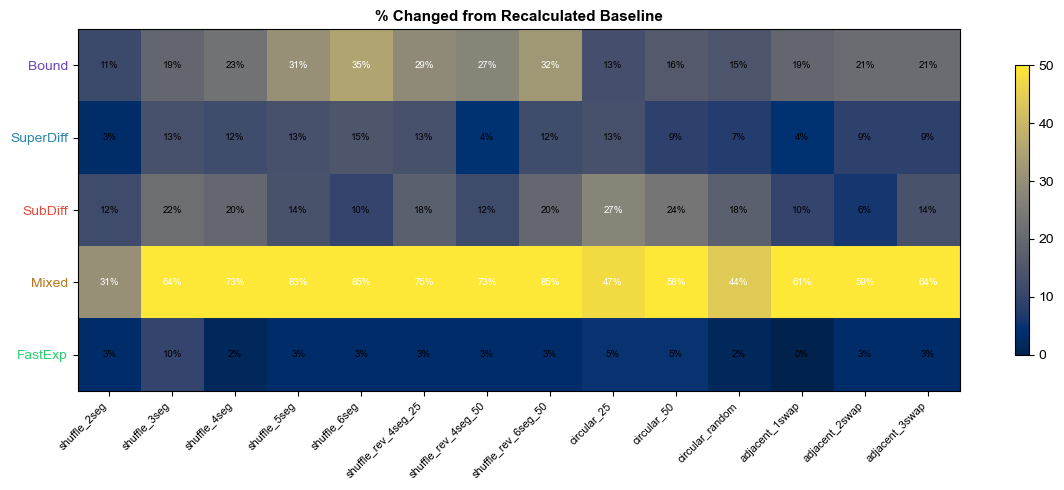

In [25]:
# [11] STABILITY HEATMAP
aug_names = list(SEGMENT_SHUFFLE_CONFIG.keys())
matrix = np.zeros((len(POP_ORDER), len(aug_names)))
for j, a in enumerate(aug_names):
    for i, p in enumerate(POP_ORDER):
        if a in results_by_aug_by_pop and p in results_by_aug_by_pop[a]:
            d = results_by_aug_by_pop[a][p]
            tot = d['stable'] + d['changed']
            matrix[i, j] = 100 * d['changed'] / tot if tot > 0 else 0

fig, ax = plt.subplots(figsize=(max(12, len(aug_names)*0.7), 5))
cmap = 'cividis'
im = ax.imshow(matrix, cmap=cmap, aspect='auto', vmin=0, vmax=50)
for i in range(len(POP_ORDER)):
    for j in range(len(aug_names)):
        ax.text(j, i, f'{matrix[i,j]:.0f}%', ha='center', va='center', fontsize=7, color='white' if matrix[i,j] > 25 else 'black')
ax.set_xticks(np.arange(len(aug_names))); ax.set_xticklabels(aug_names, rotation=45, ha='right', fontsize=8)
ax.set_yticks(np.arange(len(POP_ORDER))); ax.set_yticklabels([POP_ABBREV[p] for p in POP_ORDER], fontsize=10)
for i, p in enumerate(POP_ORDER): ax.get_yticklabels()[i].set_color(POP_COLORS[p])
ax.set_title('% Changed from Recalculated Baseline', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8); plt.tight_layout()
fig.savefig(OUTPUT_FOLDER / 'segment_shuffle_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()

DIAG-12: Track selection by RECALCULATED population
  Bound: 62 available → 1 for viz ✅
  SuperDiff: 67 available → 1 for viz ✅
  SubDiff: 51 available → 1 for viz ✅
  Mixed: 59 available → 1 for viz ✅
  FastExp: 61 available → 1 for viz ✅

=== Basic Shuffle ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=4.651, intersect=217, alpha=0.072, disp=2.720
        RECALC features: speed=4.609, intersect=217, alpha=0.072, disp=2.720
        Augs: Bound, Bound, Bound, Bound, Bound
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.903, intersect=32, alpha=2.174, disp=2.932
        RECALC features: speed=4.970, intersect=32, alpha=2.174, disp=2.932
        Augs: Super, Super, Super, Super, Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.733, intersect=33, alpha=0.411, disp=5.176
        RECALC features: speed=8.773, intersect=33, alpha=0.411, disp=5.176
        Augs: SubDi, SubDi, SubDi, SubDi, SubDi
R

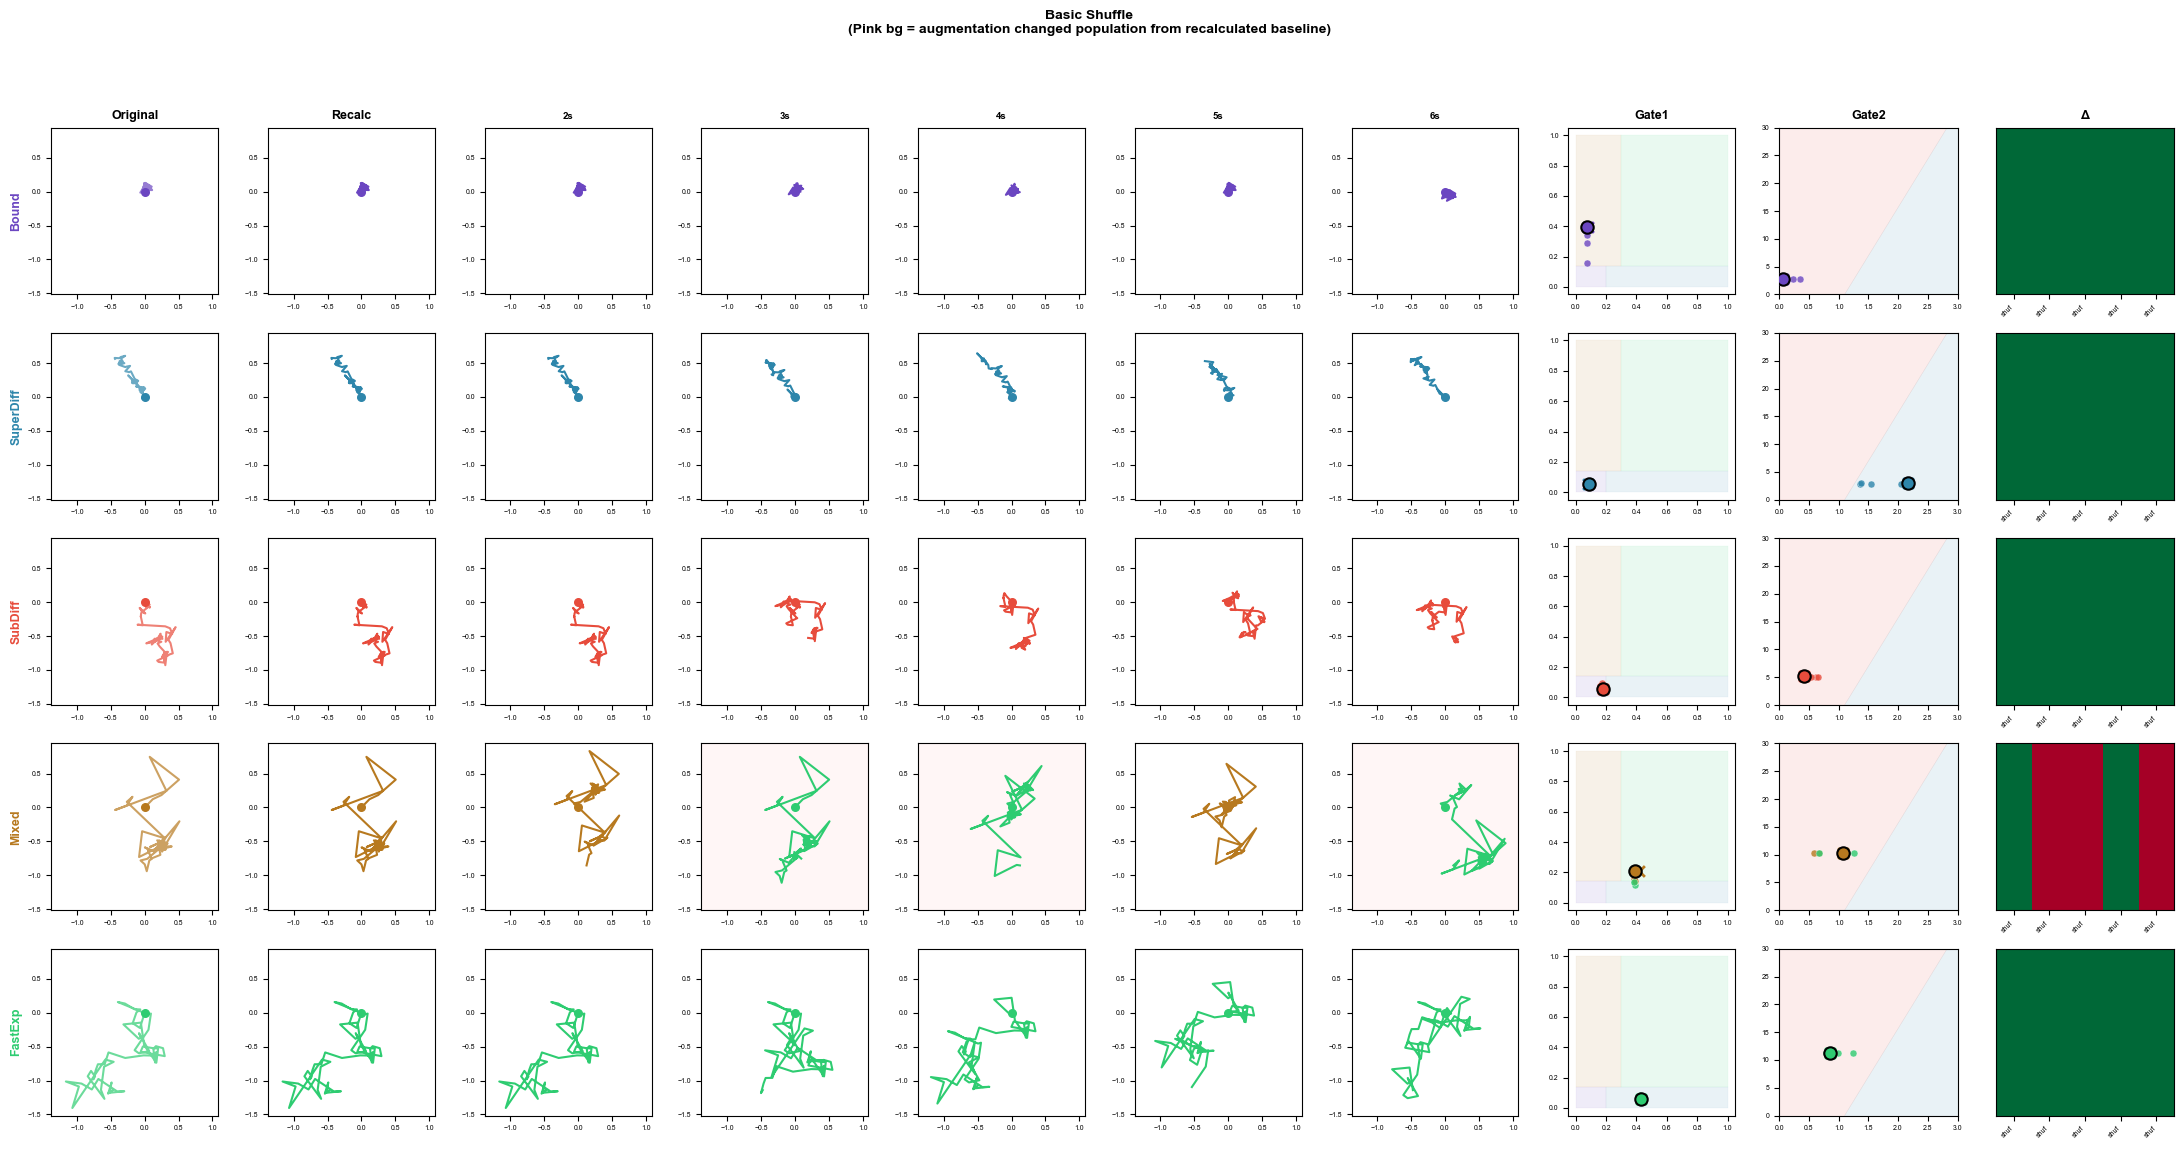


=== Shuffle+Reverse ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=4.651, intersect=217, alpha=0.072, disp=2.720
        RECALC features: speed=4.609, intersect=217, alpha=0.072, disp=2.720
        Augs: Bound, Bound, Bound
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.903, intersect=32, alpha=2.174, disp=2.932
        RECALC features: speed=4.970, intersect=32, alpha=2.174, disp=2.932
        Augs: Super, Super, Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.733, intersect=33, alpha=0.411, disp=5.176
        RECALC features: speed=8.773, intersect=33, alpha=0.411, disp=5.176
        Augs: SubDi, SubDi, SubDi
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=18.564, intersect=115, alpha=1.078, disp=10.382
        RECALC features: speed=17.597, intersect=115, alpha=1.078, disp=10.382
        Augs: FastE, FastE, FastE
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)


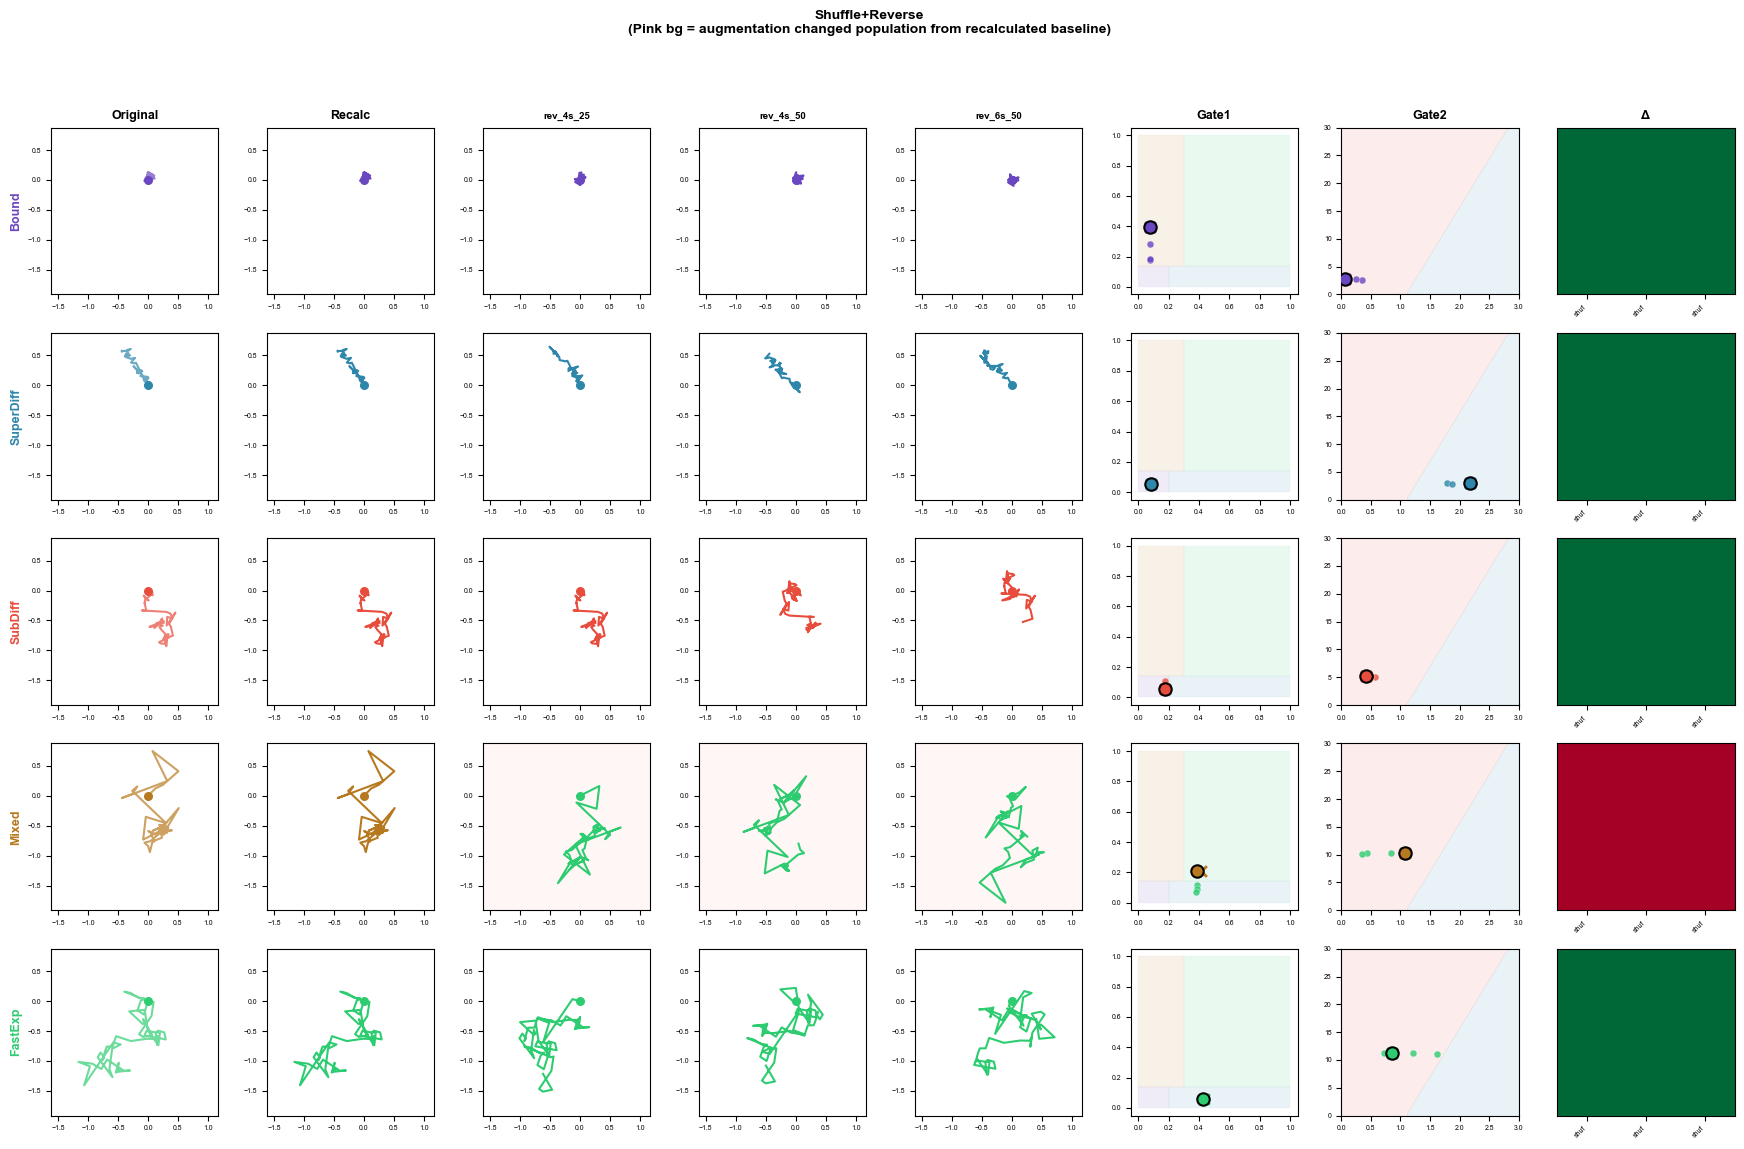


=== Circular ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=4.651, intersect=217, alpha=0.072, disp=2.720
        RECALC features: speed=4.609, intersect=217, alpha=0.072, disp=2.720
        Augs: Bound, Bound, Bound
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.903, intersect=32, alpha=2.174, disp=2.932
        RECALC features: speed=4.970, intersect=32, alpha=2.174, disp=2.932
        Augs: Super, Super, Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.733, intersect=33, alpha=0.411, disp=5.176
        RECALC features: speed=8.773, intersect=33, alpha=0.411, disp=5.176
        Augs: SubDi, SubDi, SubDi
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=18.564, intersect=115, alpha=1.078, disp=10.382
        RECALC features: speed=17.597, intersect=115, alpha=1.078, disp=10.382
        Augs: Mixed, Mixed, Mixed
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)
       

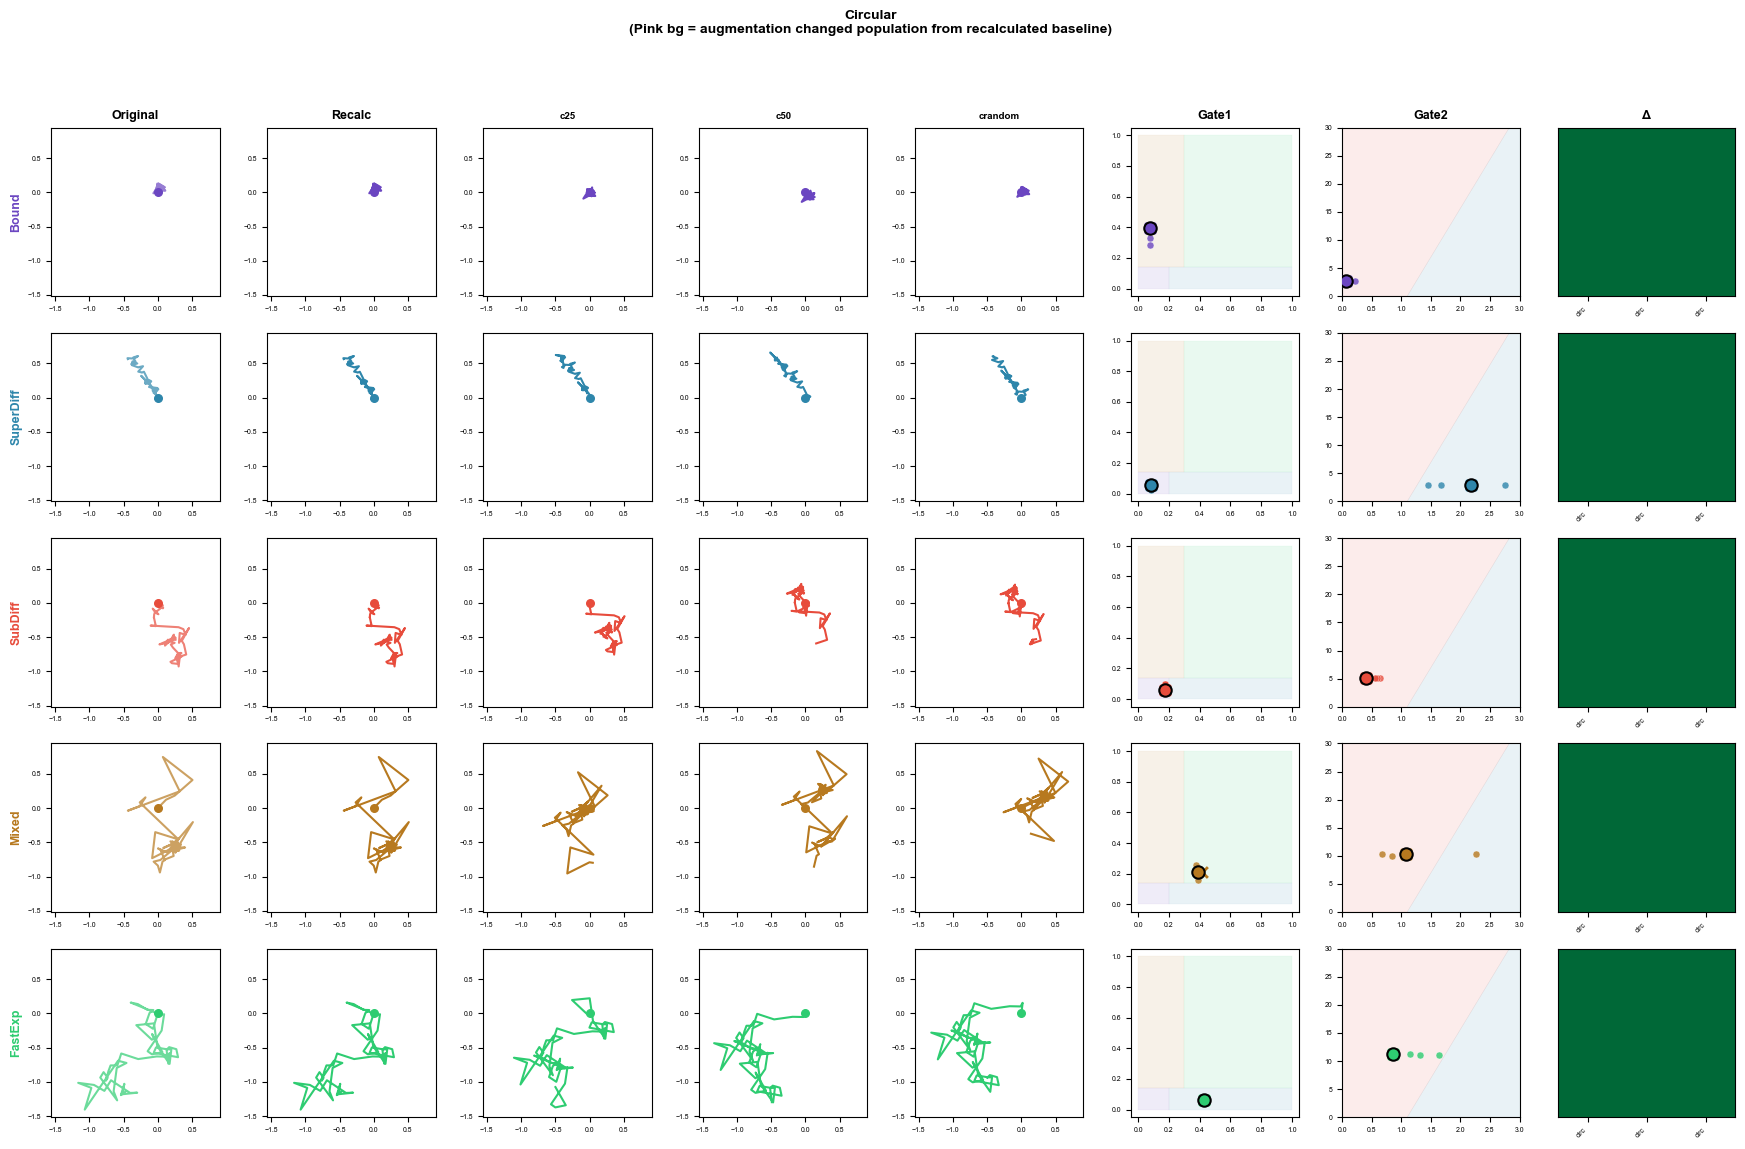


=== Adjacent ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=4.651, intersect=217, alpha=0.072, disp=2.720
        RECALC features: speed=4.609, intersect=217, alpha=0.072, disp=2.720
        Augs: Bound, Bound, Bound
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.903, intersect=32, alpha=2.174, disp=2.932
        RECALC features: speed=4.970, intersect=32, alpha=2.174, disp=2.932
        Augs: Super, Super, Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.733, intersect=33, alpha=0.411, disp=5.176
        RECALC features: speed=8.773, intersect=33, alpha=0.411, disp=5.176
        Augs: SubDi, SubDi, SubDi
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=18.564, intersect=115, alpha=1.078, disp=10.382
        RECALC features: speed=17.597, intersect=115, alpha=1.078, disp=10.382
        Augs: FastE, Mixed, FastE
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)
       

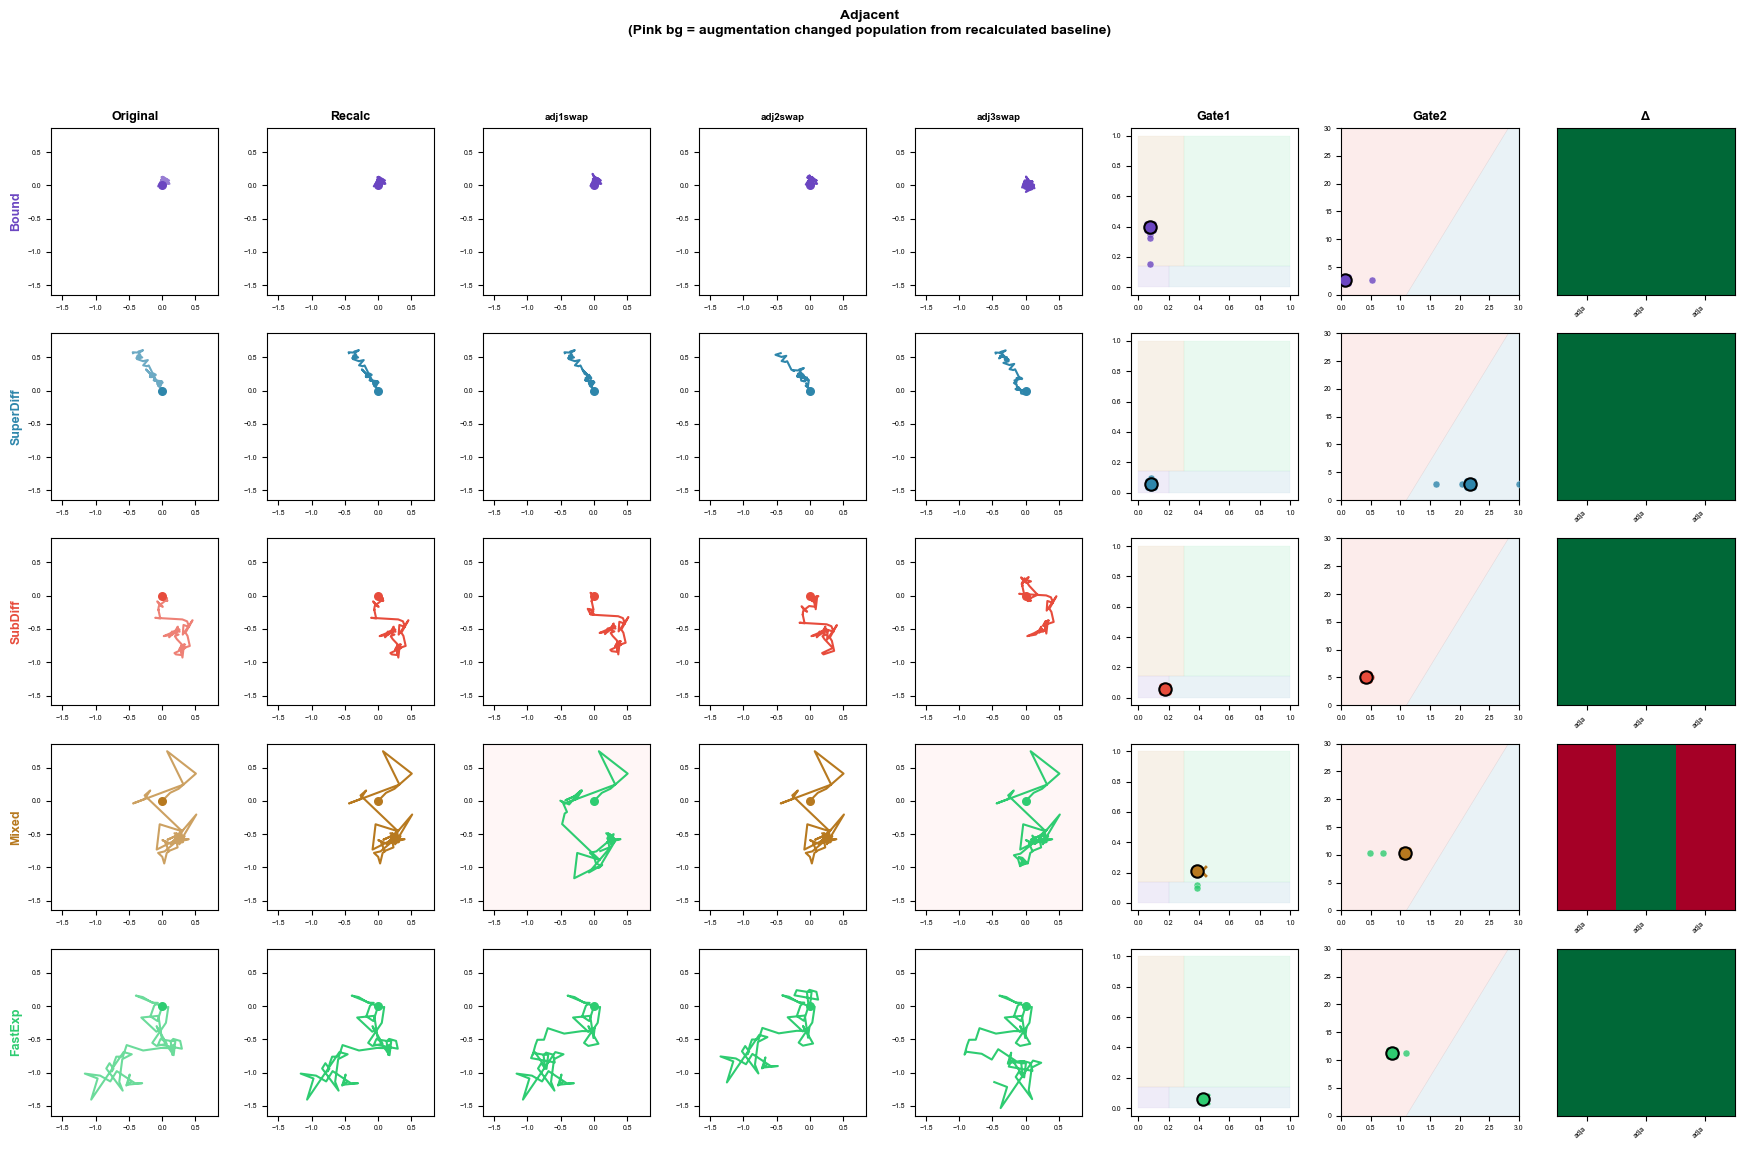


LEGEND:
  Row label: Shows RECALCULATED population (what the row represents)
  Column 1 (Original): Track colored by ORIGINAL population (may differ from row!)
  Column 2 (Recalc): Track colored by RECALCULATED population (matches row label)
  Augmented columns: Track colored by its FINAL GATED population after augmentation
  Pink background: Augmentation changed population from recalculated baseline
  Heatmap: Green=stable, Red=changed (comparing augmented vs recalculated)
  Gate plots: ○ = recalc position, × = original position (if SHOW_ORIGINAL_ON_GATES=True)
Note: SHOW_ORIGINAL_ON_GATES = True
Done!


In [27]:
# [12] TRACK PANELS - Original | Recalculated | Augmentations
# NOTE: Run cells 7-11 first!
# IMPORTANT: We select tracks by their RECALCULATED population (not original!)
#            This ensures each row shows a TRUE example of that behavior type
#            All comparisons are RECALCULATED vs AUGMENTED

# OPTION: Show original track position on gate plots as 'x' marker
SHOW_ORIGINAL_ON_GATES = True  # Set to False to hide original markers

# Group tracks by their RECALCULATED population (this is what matters for analysis)
tracks_by_recalc_pop = {p: [] for p in POP_ORDER}
for parent_uid in all_parent_uids:
    rec = classified_df.filter(pl.col('window_uid') == f'{parent_uid}_recalculated')
    if rec.height > 0:
        rec_pop = rec['final_population'][0]
        if rec_pop in tracks_by_recalc_pop:
            tracks_by_recalc_pop[rec_pop].append(parent_uid)

# RANDOMIZE selection for each population, then take N_TRACKS_VIZ
viz_tracks = {}
for p in POP_ORDER:
    pool = tracks_by_recalc_pop.get(p, []).copy()
    np.random.shuffle(pool)  # Randomize!
    viz_tracks[p] = pool[:N_TRACKS_VIZ]

# DIAGNOSTIC: What tracks do we have?
print("="*70)
print("DIAG-12: Track selection by RECALCULATED population")
print("="*70)
for p in POP_ORDER:
    available = len(tracks_by_recalc_pop.get(p, []))
    viz = len(viz_tracks.get(p, []))
    status = "✅" if viz >= N_TRACKS_VIZ else ("⚠️ LOW" if viz > 0 else "❌ NONE")
    print(f"  {POP_ABBREV[p]}: {available} available → {viz} for viz {status}")

for group_name, aug_list in SEGMENT_GROUPS.items():
    print(f'\n{"="*70}')
    print(f'=== {group_name} ===')
    print("="*70)
    track_rows = [(p, u) for p in POP_ORDER for u in viz_tracks.get(p, [])]
    if not track_rows:
        print("No tracks - skipping")
        continue
    
    n_rows, n_aug = len(track_rows), len(aug_list)
    n_cols = 2 + n_aug + 3  # Original | Recalc | Augs | Gate1 | Gate2 | Heatmap
    
    # Pre-cache tracks and compute global limits
    cache = {}; gmin_x, gmax_x, gmin_y, gmax_y = np.inf, -np.inf, np.inf, -np.inf
    for pop, uid in track_rows:
        tdf = get_window_frames(instant_df, uid)
        if tdf.height == 0: continue
        x, y = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy()
        xc, yc = x - x[0], y - y[0]
        cache[uid] = {'x': x, 'y': y, 'xc': xc, 'yc': yc, 'dt': tdf['delta_time_s'].to_numpy(), 'aug': {}}
        gmin_x, gmax_x = min(gmin_x, xc.min()), max(gmax_x, xc.max())
        gmin_y, gmax_y = min(gmin_y, yc.min()), max(gmax_y, yc.max())
        for a in aug_list:
            seed = hash(f'{uid}_{a}') % 2**32
            xa, ya = apply_aug(x, y, a, seed)
            xac, yac = xa - xa[0], ya - ya[0]
            cache[uid]['aug'][a] = {'xc': xac, 'yc': yac}
            gmin_x, gmax_x = min(gmin_x, xac.min()), max(gmax_x, xac.max())
            gmin_y, gmax_y = min(gmin_y, yac.min()), max(gmax_y, yac.max())
    
    rng = max(gmax_x - gmin_x, gmax_y - gmin_y) * 1.1
    cx, cy = (gmax_x + gmin_x) / 2, (gmax_y + gmin_y) / 2
    xlim, ylim = (cx - rng/2, cx + rng/2), (cy - rng/2, cy + rng/2)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2*n_cols, 2.2*n_rows))
    if n_rows == 1: axes = axes.reshape(1, -1)
    
    for ri, (pop, uid) in enumerate(track_rows):
        if uid not in cache: continue
        c = cache[uid]
        
        # pop = RECALCULATED population (what we selected by)
        pop_color = POP_COLORS.get(pop, '#888')
        
        # Get recalculated data (pop should match since we selected by recalc population)
        rec = classified_df.filter(pl.col('window_uid') == f'{uid}_recalculated')
        rec_pop = rec['final_population'][0] if rec.height > 0 else pop
        
        # Get ORIGINAL population for comparison (may be different!)
        orig_row = windowed_df.filter(pl.col('window_uid') == uid)
        orig_pop = orig_row['final_population'][0] if orig_row.height > 0 else 'unknown'
        orig_color = POP_COLORS.get(orig_pop, '#888')
        
        # DIAGNOSTIC: Show what original was vs what recalc is (row label) + features
        changed = "→" if orig_pop != pop else "="
        print(f"Row {ri}: RECALC={POP_ABBREV.get(pop,'?'):<8} (was ORIG={POP_ABBREV.get(orig_pop,'?'):<8} {changed})")
        
        # Print feature comparison: ORIGINAL vs RECALCULATED
        if orig_row.height > 0 and rec.height > 0:
            print(f"        ORIG  features: speed={orig_row['avg_speed_um_s'][0]:.3f}, intersect={orig_row['self_intersections'][0]}, alpha={orig_row['anomalous_exponent'][0]:.3f}, disp={orig_row['cum_displacement_um'][0]:.3f}")
            print(f"        RECALC features: speed={rec['avg_speed_um_s'][0]:.3f}, intersect={rec['self_intersections'][0]}, alpha={rec['anomalous_exponent'][0]:.3f}, disp={rec['cum_displacement_um'][0]:.3f}")
        
        ci = 0
        
        # Column 0: ORIGINAL track (colored by ORIGINAL population - may differ from row label!)
        ax = axes[ri, ci]
        ax.plot(c['xc'], c['yc'], color=orig_color, lw=1.5, alpha=0.7)
        ax.scatter([0], [0], c=orig_color, s=30, marker='o', zorder=5)
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
        if ri == 0: ax.set_title('Original', fontsize=9, fontweight='bold')
        # Row label shows RECALCULATED population (what the row represents)
        ax.set_ylabel(POP_ABBREV.get(pop, pop), fontsize=9, color=pop_color, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # Column 1: RECALCULATED track (colored by RECALCULATED population = row label)
        ax = axes[ri, ci]
        ax.plot(c['xc'], c['yc'], color=pop_color, lw=1.5)
        ax.scatter([0], [0], c=pop_color, s=30, marker='o', zorder=5)
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
        if ri == 0: ax.set_title('Recalc', fontsize=9, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # Augmented tracks (colored by THEIR FINAL POPULATION)
        aug_info = []
        for a in aug_list:
            ax = axes[ri, ci]
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            aug_pop = ar['final_population'][0] if ar.height > 0 else 'unknown'
            aug_color = POP_COLORS.get(aug_pop, '#888')
            aug_info.append(f"{POP_ABBREV.get(aug_pop,'?')[:5]}")
            ad = c['aug'].get(a, {})
            if 'xc' in ad:
                ax.plot(ad['xc'], ad['yc'], color=aug_color, lw=1.5)
                ax.scatter([0], [0], c=aug_color, s=30, zorder=5)
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
            short = a.replace('shuffle_', '').replace('seg', 's').replace('circular_', 'c').replace('adjacent_', 'adj')
            if ri == 0: ax.set_title(short, fontsize=7, fontweight='bold')
            # Highlight if different from RECALCULATED baseline (the fair comparison)
            if aug_pop != rec_pop: ax.patch.set_facecolor('#FFEEEE'); ax.patch.set_alpha(0.5)
            ax.tick_params(labelsize=5); ci += 1
        print(f"        Augs: {', '.join(aug_info)}")
        
        # Gate 1 plot - show recalc baseline (large circle) and augmented (small dots)
        ax = axes[ri, ci]
        for g, p in GATE1_RECTS.items():
            ax.add_patch(Rectangle((p['x'][0], p['y'][0]), p['x'][1]-p['x'][0], p['y'][1]-p['y'][0], alpha=0.1, fc=p['color'], ec=p['color'], lw=0.3))
        # Optional: Show ORIGINAL position as 'x' marker
        if SHOW_ORIGINAL_ON_GATES and orig_row.height > 0:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                sc_orig = scaler.transform([[orig_row['avg_speed_um_s'][0], orig_row['self_intersections'][0]]])[0]
            ax.scatter(sc_orig[0], sc_orig[1], c=orig_color, s=60, marker='x', lw=2, zorder=8, label='orig')
        if rec.height > 0:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                sc = scaler.transform([[rec['avg_speed_um_s'][0], rec['self_intersections'][0]]])[0]
            # Large circle for recalc baseline in population color
            ax.scatter(sc[0], sc[1], c=pop_color, s=80, marker='o', ec='black', lw=1.5, zorder=10)
        for a in aug_list:
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            if ar.height > 0:
                ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    sc = scaler.transform([[ar['avg_speed_um_s'][0], ar['self_intersections'][0]]])[0]
                ax.scatter(sc[0], sc[1], c=ac, s=25, ec='white', lw=0.3, alpha=0.8, zorder=5)
        ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, 1.05); ax.set_aspect('equal')
        if ri == 0: ax.set_title('Gate1', fontsize=9, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # Gate 2 plot
        ax = axes[ri, ci]
        ax.add_patch(Polygon(GATE2_BOUNDS['superdiffusive'], alpha=0.1, fc='#2E86AB', ec='#2E86AB', lw=0.3))
        ax.add_patch(Polygon(GATE2_BOUNDS['subdiffusive'], alpha=0.1, fc='#E74C3C', ec='#E74C3C', lw=0.3))
        # Optional: Show ORIGINAL position as 'x' marker
        if SHOW_ORIGINAL_ON_GATES and orig_row.height > 0:
            ax.scatter(orig_row['anomalous_exponent'][0], orig_row['cum_displacement_um'][0], c=orig_color, s=60, marker='x', lw=2, zorder=8)
        if rec.height > 0:
            # Large circle for recalc baseline in population color
            ax.scatter(rec['anomalous_exponent'][0], rec['cum_displacement_um'][0], c=pop_color, s=80, marker='o', ec='black', lw=1.5, zorder=10)
        for a in aug_list:
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            if ar.height > 0:
                ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
                ax.scatter(ar['anomalous_exponent'][0], ar['cum_displacement_um'][0], c=ac, s=25, ec='white', lw=0.3, alpha=0.8, zorder=5)
        ax.set_xlim(0, 3); ax.set_ylim(0, 30)  # Extended to match gate bounds (max cum_disp ~28)
        if ri == 0: ax.set_title('Gate2', fontsize=9, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # HEATMAP: Did augmentation change population from RECALCULATED baseline?
        ax = axes[ri, ci]
        aug_changes = []
        for a in aug_list:
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            aug_changes.append(1 if ar.height > 0 and ar['final_population'][0] != rec_pop else 0)
        ax.imshow([aug_changes], cmap='RdYlGn_r', vmin=0, vmax=1, aspect='auto')
        ax.set_xticks(np.arange(len(aug_list))); ax.set_xticklabels([a[:4] for a in aug_list], fontsize=5, rotation=45, ha='right')
        ax.set_yticks([])
        if ri == 0: ax.set_title('Δ', fontsize=9, fontweight='bold')
    
    plt.suptitle(f'{group_name}\n(Pink bg = augmentation changed population from recalculated baseline)', fontsize=10, fontweight='bold', y=1.04)
    plt.tight_layout()
    safe = group_name.lower().replace(' ', '_').replace('+', '_')
    fig.savefig(OUTPUT_FOLDER / f'track_panel_{safe}.svg', format='svg', bbox_inches='tight')
    plt.show()

print("\n" + "="*70)
print("LEGEND:")
print("  Row label: Shows RECALCULATED population (what the row represents)")
print("  Column 1 (Original): Track colored by ORIGINAL population (may differ from row!)")
print("  Column 2 (Recalc): Track colored by RECALCULATED population (matches row label)")
print("  Augmented columns: Track colored by its FINAL GATED population after augmentation")
print("  Pink background: Augmentation changed population from recalculated baseline")
print("  Heatmap: Green=stable, Red=changed (comparing augmented vs recalculated)")
print("  Gate plots: ○ = recalc position, × = original position (if SHOW_ORIGINAL_ON_GATES=True)")
print("="*70)
print(f"Note: SHOW_ORIGINAL_ON_GATES = {SHOW_ORIGINAL_ON_GATES}")
print('Done!')

# Augmentation Methods Overview

## 1. SEGMENT SHUFFLE (shuffle_Nseg)
Split track into N equal segments, randomly reorder them.

```
Original:    [A]-[B]-[C]-[D]    (4 segments)
Augmented:   [C]-[A]-[D]-[B]    (random permutation)

Severity ↑ (more segments):
  2seg:  [██████]-[██████]           → Mild (only 2 pieces to swap)
  4seg:  [███]-[███]-[███]-[███]     → Moderate  
  12seg: [█][█][█][█][█][█]...       → Extreme (many tiny pieces)
```
**Effect**: More segments = more disruption to trajectory continuity, but preserves local motion patterns within each segment.

---

## 2. SHUFFLE WITH REVERSAL (shuffle_rev_Nseg_P%)
Split into N segments, shuffle, AND reverse P% of segments.

```
Original:    [A→]-[B→]-[C→]-[D→]
Augmented:   [C→]-[←A]-[D→]-[←B]   (some segments reversed)

Severity ↑:
  shuffle_rev_4seg_25:  25% of segments reversed
  shuffle_rev_4seg_50:  50% of segments reversed
  shuffle_rev_6seg_50:  More segments + 50% reversed
```
**Effect**: Reversal changes local velocity direction within segments. Higher % = more direction changes.

---

## 3. CIRCULAR PERMUTATION (circular_P%)
Shift the starting point by P% of track length (like rotating a ring).

```
Original:    [A]-[B]-[C]-[D]
circular_25: [B]-[C]-[D]-[A]    (shift by 25%)
circular_50: [C]-[D]-[A]-[B]    (shift by 50%)

Severity ↑:
  circular_25:    Shift by 25% of track length
  circular_50:    Shift by 50% (most different start point)
  circular_random: Random shift amount
```
**Effect**: MILDEST augmentation - preserves ALL temporal relationships, just changes start point. Perfect for rotation-invariant training.

---

## 4. ADJACENT SWAP (adjacent_Nswap)
Swap N pairs of adjacent segments (gentler than full shuffle).

```
Original:    [A]-[B]-[C]-[D]-[E]-[F]
adjacent_1:  [B]-[A]-[C]-[D]-[E]-[F]    (swap 1 pair)
adjacent_2:  [B]-[A]-[D]-[C]-[E]-[F]    (swap 2 pairs)
adjacent_3:  [B]-[A]-[D]-[C]-[F]-[E]    (swap 3 pairs)

Severity ↑:
  adjacent_1swap: 1 pair swapped → very mild
  adjacent_2swap: 2 pairs swapped → mild
  adjacent_3swap: 3 pairs swapped → moderate
```
**Effect**: Localized disruption - maintains most of the trajectory flow. Good for subtle augmentation.

---

## Summary Table

| Method | Disruption | Preserves | Best For |
|--------|-----------|-----------|----------|
| circular | Very Low | All temporal relationships | Start-point invariance |
| adjacent_1-2 | Low | Most trajectory flow | Subtle augmentation |
| shuffle_2-3seg | Moderate | Local motion in segments | Balanced augmentation |
| shuffle_4-6seg | High | Smaller local patterns | Aggressive augmentation |
| shuffle_rev_* | Very High | Very little | Stress-testing |
| shuffle_10-12seg | Extreme | Almost nothing | Edge case testing |

In [ ]:
# [DECISION HELPER] Which augmentations to use for training?
# Goal: "As different as possible while still remaining same category"

print("="*70)
print("AUGMENTATION SELECTION ANALYSIS")
print("Goal: Maximize diversity while preserving category")
print("="*70)

# Calculate stability for each augmentation
aug_stability = []
for aug_name, counts in results_by_aug.items():
    total = counts['stable'] + counts['changed']
    if total > 0:
        stability = 100 * counts['stable'] / total
        aug_stability.append((aug_name, stability, counts['stable'], counts['changed']))

# Sort by stability (highest = most safe)
aug_stability.sort(key=lambda x: -x[1])

print(f"\n{'Augmentation':<25} {'Stable':>8} {'Changed':>8} {'Stability':>10} {'Recommendation':<25}")
print("-" * 85)
for aug, stab, stable, changed in aug_stability:
    if stab >= 95:
        rec = "✅ EXCELLENT"
    elif stab >= 90:
        rec = "✅ GOOD"
    elif stab >= 80:
        rec = "⚠️ MODERATE"
    elif stab >= 70:
        rec = "⚠️ RISKY"
    else:
        rec = "❌ AVOID"
    print(f"{aug:<25} {stable:>8} {changed:>8} {stab:>9.1f}%  {rec}")

# Group by recommendation tier
excellent = [(a, s) for a, s, _, _ in aug_stability if s >= 95]
good = [(a, s) for a, s, _, _ in aug_stability if 90 <= s < 95]
moderate = [(a, s) for a, s, _, _ in aug_stability if 80 <= s < 90]
risky = [(a, s) for a, s, _, _ in aug_stability if s < 80]

print("\n" + "="*70)
print("RECOMMENDATIONS FOR NETWORK TRAINING")
print("="*70)

if excellent:
    print(f"\n✅ TIER 1 - Use freely (≥95% stability):")
    for a, s in excellent:
        print(f"   {a}: {s:.1f}%")
    
if good:
    print(f"\n✅ TIER 2 - Recommended (90-95%):")
    for a, s in good:
        print(f"   {a}: {s:.1f}%")
    
if moderate:
    print(f"\n⚠️ TIER 3 - Use sparingly (80-90%):")
    for a, s in moderate:
        print(f"   {a}: {s:.1f}%")

if risky:
    print(f"\n❌ AVOID - Too disruptive (<80%):")
    for a, s in risky:
        print(f"   {a}: {s:.1f}%")

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
SUGGESTED TRAINING COMBINATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

CONSERVATIVE (safest):
  • circular_25, circular_50 - preserves everything, just shifts start
  • adjacent_1swap - minimal disruption
  
BALANCED (recommended for most cases):
  • circular_* + adjacent_1-2swap + shuffle_2-3seg
  • Good diversity without excessive category changes
  
AGGRESSIVE (if model overfits):
  • Add shuffle_4-6seg to the above
  • Monitor validation closely for category confusion

KEY INSIGHT: CIRCULAR augmentations are special!
  → They create visually different tracks
  → BUT preserve ALL computed features (speed, alpha, displacement, intersections)
  → Perfect for teaching start-point invariance without changing labels

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")
print("="*70)

In [20]:
# [13] VERIFICATION: FEATURE RECALCULATION ACCURACY
# Compare ORIGINAL features (from windowed_df) vs RECALCULATED features (our compute_features)
# This checks if our calculation method matches the original pipeline

print("="*70)
print("VERIFICATION: FEATURE RECALCULATION ACCURACY")
print("="*70)
print("Comparing: Original features (from windowed_df) vs Recalculated (compute_features)")
print("Using actual delta_time_s from each track for exact calculation\n")

# Features to compare
FEATURES = ['avg_speed_um_s', 'cum_displacement_um', 'self_intersections', 'anomalous_exponent']

print(f"{'Track':<35} | {'Feature':<20} | {'Original':<12} | {'Recalc':<12} | {'Diff':<12}")
print("-" * 100)

all_diffs = {f: [] for f in FEATURES}
n_shown = 0

for pop in POP_ORDER[:3]:  # Show 3 populations
    pop_uids = selected_parents.get(pop, [])[:2]  # 2 tracks per pop
    
    for uid in pop_uids:
        # Get original row from windowed_df
        orig_row = windowed_df.filter(pl.col('window_uid') == uid)
        if orig_row.height == 0:
            continue
        
        # Get track data and recalculate
        tdf = get_window_frames(instant_df, uid)
        if tdf.height == 0:
            continue
        x, y = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy()
        dt = tdf['delta_time_s'].to_numpy()
        
        recalc = compute_features(x, y, dt)
        
        uid_short = uid[:33] + ".." if len(uid) > 35 else uid
        
        for i, feat in enumerate(FEATURES):
            orig_val = orig_row[feat][0]
            recalc_val = recalc[feat]
            
            if orig_val is not None and not np.isnan(orig_val):
                diff = recalc_val - orig_val
                pct_diff = 100 * diff / orig_val if orig_val != 0 else 0
                all_diffs[feat].append(diff)
                
                status = "✅" if abs(pct_diff) < 5 else "⚠️" if abs(pct_diff) < 20 else "❌"
                
                # Only print track name on first feature
                track_col = uid_short if i == 0 else ""
                print(f"{track_col:<35} | {feat:<20} | {orig_val:>12.4f} | {recalc_val:>12.4f} | {diff:>+11.4f} {status}")
        
        print()  # Blank line between tracks
        n_shown += 1

# Summary
print("="*70)
print("SUMMARY:")
print("="*70)
for feat in FEATURES:
    diffs = all_diffs[feat]
    if len(diffs) > 0:
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)
        max_diff = np.max(np.abs(diffs))
        status = "✅ GOOD" if abs(mean_diff) < 0.1 * np.mean(np.abs(diffs) + 1e-10) else "⚠️ CHECK"
        print(f"  {feat:<25}: mean={mean_diff:+.4f}, std={std_diff:.4f}, max|diff|={max_diff:.4f} {status}")

print("\nNote: Small differences are expected due to floating point precision.")
print("Large differences (❌) may indicate calculation method mismatch.")


VERIFICATION: FEATURE RECALCULATION ACCURACY
Comparing: Original features (from windowed_df) vs Recalculated (compute_features)
Using actual delta_time_s from each track for exact calculation

Track                               | Feature              | Original     | Recalc       | Diff        
----------------------------------------------------------------------------------------------------
ncmrw_26_14703_R1_34_3027.0_3086.0  | avg_speed_um_s       |       6.5429 |       6.5960 |     +0.0531 ✅
                                    | cum_displacement_um  |       3.8916 |       3.8916 |     +0.0000 ✅
                                    | self_intersections   |     225.0000 |     225.0000 |     +0.0000 ✅
                                    | anomalous_exponent   |       0.2052 |       0.2052 |     +0.0000 ✅

nch1h_2_25012_R1_22_3326.0_3385.0   | avg_speed_um_s       |       4.9871 |       4.8616 |     -0.1255 ✅
                                    | cum_displacement_um  |       2.8683 | 

In [26]:
# AUGMENTATION SELECTION HELPER
# Goal: "As different as possible while still remaining same category"

print("="*70)
print("AUGMENTATION SELECTION ANALYSIS")
print("="*70)
print("""
AUGMENTATION METHODS (Low → High Disruption):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. CIRCULAR (circular_25/50/random)
   - Shifts start point only, preserves ALL temporal relationships
   - MILDEST: Perfect for rotation-invariant training
   
2. ADJACENT SWAP (adjacent_1/2/3swap)  
   - Swaps neighboring segment pairs
   - MILD: Localized disruption, maintains trajectory flow
   
3. SHUFFLE 2-3 segments (shuffle_2seg/3seg)
   - Reorders 2-3 large chunks
   - MODERATE: Good balance of difference vs preservation
   
4. SHUFFLE 4-6 segments (shuffle_4seg/5seg/6seg)
   - Reorders more, smaller chunks
   - HIGH: Significant disruption to trajectory continuity
   
5. SHUFFLE + REVERSAL (shuffle_rev_*)
   - Shuffle + reverse some segments (changes velocity direction!)
   - VERY HIGH: Changes both order AND local motion direction
   
6. SHUFFLE 10-12 segments (shuffle_10seg/12seg)
   - Many tiny pieces shuffled
   - EXTREME: Almost complete scrambling
""")

# Analyze stability results
print("\n" + "="*70)
print("STABILITY ANALYSIS: % of tracks that KEPT their category")
print("="*70)

# Calculate stability for each augmentation
aug_stability = []
for aug_name, counts in results_by_aug.items():
    total = counts['stable'] + counts['changed']
    if total > 0:
        stability = 100 * counts['stable'] / total
        aug_stability.append((aug_name, stability, total))

# Sort by stability (highest = most safe)
aug_stability.sort(key=lambda x: -x[1])

print(f"\n{'Augmentation':<25} {'Stability %':>12} {'Recommendation':<20}")
print("-" * 60)
for aug, stab, total in aug_stability:
    if stab >= 95:
        rec = "✅ EXCELLENT - use freely"
    elif stab >= 90:
        rec = "✅ GOOD - recommended"
    elif stab >= 80:
        rec = "⚠️ MODERATE - use carefully"
    elif stab >= 70:
        rec = "⚠️ RISKY - limited use"
    else:
        rec = "❌ AVOID - too disruptive"
    print(f"{aug:<25} {stab:>10.1f}%  {rec}")

# Summary recommendation
print("\n" + "="*70)
print("RECOMMENDATIONS FOR TRAINING:")
print("="*70)

# Get top augmentations by stability
excellent = [a for a, s, _ in aug_stability if s >= 95]
good = [a for a, s, _ in aug_stability if 90 <= s < 95]
moderate = [a for a, s, _ in aug_stability if 80 <= s < 90]

if excellent:
    print(f"\n✅ TIER 1 (≥95% stability) - Use freely:")
    for a in excellent: print(f"   • {a}")
    
if good:
    print(f"\n✅ TIER 2 (90-95% stability) - Recommended:")
    for a in good: print(f"   • {a}")
    
if moderate:
    print(f"\n⚠️ TIER 3 (80-90% stability) - Use with caution:")
    for a in moderate: print(f"   • {a}")

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
SUGGESTED TRAINING STRATEGY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Start with TIER 1 augmentations (safest)
2. Add TIER 2 if you need more variety
3. Consider TIER 3 only if model is overfitting

The "best" augmentation maximizes:
  • Trajectory diversity (different track shapes)
  • Category preservation (stays same population)
  
CIRCULAR augmentations are ideal because they create
different-looking tracks while preserving ALL features!
""")

print("="*70)

AUGMENTATION SELECTION ANALYSIS

AUGMENTATION METHODS (Low → High Disruption):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. CIRCULAR (circular_25/50/random)
   - Shifts start point only, preserves ALL temporal relationships
   - MILDEST: Perfect for rotation-invariant training
   
2. ADJACENT SWAP (adjacent_1/2/3swap)  
   - Swaps neighboring segment pairs
   - MILD: Localized disruption, maintains trajectory flow
   
3. SHUFFLE 2-3 segments (shuffle_2seg/3seg)
   - Reorders 2-3 large chunks
   - MODERATE: Good balance of difference vs preservation
   
4. SHUFFLE 4-6 segments (shuffle_4seg/5seg/6seg)
   - Reorders more, smaller chunks
   - HIGH: Significant disruption to trajectory continuity
   
5. SHUFFLE + REVERSAL (shuffle_rev_*)
   - Shuffle + reverse some segments (changes velocity direction!)
   - VERY HIGH: Changes both order AND local motion direction
   
6. SHUFFLE 10-12 segments (shuffle_10seg/12seg)
   - Many tiny pieces shuffled
   - EXTREME: Almost complete scrambling

# Augmentation Methods Overview

## 1. SEGMENT SHUFFLE (shuffle_Nseg)
Split track into N equal segments, randomly reorder them.
```
Original:    [A]-[B]-[C]-[D]    (4 segments)
Augmented:   [C]-[A]-[D]-[B]    (random permutation)
```
**Severity ↑**: More segments = more disruption to trajectory continuity

| Variant | Effect |
|---------|--------|
| 2seg | Mild - only 2 pieces to swap |
| 4seg | Moderate |
| 10-12seg | Extreme - many tiny pieces |

---

## 2. SHUFFLE + REVERSAL (shuffle_rev_Nseg_P%)
Shuffle segments AND reverse P% of them (changes velocity direction).
```
Original:    [A→]-[B→]-[C→]-[D→]
Augmented:   [C→]-[←A]-[D→]-[←B]   (some reversed)
```
**Severity ↑**: More reversal % = more direction changes

---

## 3. CIRCULAR PERMUTATION (circular_P%)
Shift starting point by P% (like rotating a ring). **MILDEST** - preserves ALL temporal relationships!
```
Original:    [A]-[B]-[C]-[D]
circular_50: [C]-[D]-[A]-[B]    (shift by 50%)
```

---

## 4. ADJACENT SWAP (adjacent_Nswap)
Swap N pairs of neighboring segments. Gentler than full shuffle.
```
Original:   [A]-[B]-[C]-[D]-[E]-[F]
adjacent_2: [B]-[A]-[D]-[C]-[E]-[F]  (2 pairs swapped)
```

---

## Summary: Disruption Level
```
circular_* < adjacent_1-2 < shuffle_2-3seg < shuffle_4-6seg < shuffle_rev_* < shuffle_10-12seg
   MILD ──────────────────────────────────────────────────────────────────────► EXTREME
```